# Dataset
The data used in this notebook comes from the [Kaggle's Electric Power Consumption dataset](https://www.kaggle.com/datasets/fedesoriano/electric-power-consumption). This dataset is a CSV file with 3 columns of electric power consumption recorded at a frequency of 6 samples per hour (1 sample every 10 minutes). Each of these 3 columns represents a zone of the city of Tétouan, in Morocco.

**Features**:
* **Date Time**: Time window of ten minutes.
* **Temperature**: Weather Temperature.
* **Humidity**: Weather Humidity.
* **Wind Speed**: Wind Speed.
* **General Diffuse Flows**: “Diffuse flow” is a catchall term to describe low-temperature (< 0.2° to ~ 100°C) fluids that slowly discharge through sulfide mounds, fractured lava flows, and assemblages of bacterial mats and macrofauna.
* **Diffuse Flows**

**Target**:
*  **Zone 1 Power Consumption**
*  **Zone 2 Power Consumption**
*  **Zone 3 Power Consumption**

## <p style="background-color:white; font-size:120%; text-align:center">Table of Content</p>

* [I. Importing/Loading & checking the data](#1)
* [II. Data visualization ](#2)
* [III. Data Preprocessing ](#3)
* [IV. Feature engineering ](#4)
* [V. Exploratory Data Analysis ](#5)
* [VI. Model](#6)
     * [ VI.1. Univariate Time Series Forecasting](#6.1)
     * [ VI.2. Multivariate Time Series Forecasting using [temperature]](#6.2)
     * [ VI.3. Multivariate Time Series Forecasting using [temperature, humidity]](#6.3)
     * [ VI.4. Multivariate Time Series Forecasting using [temperature, humidity, windSpeed]](#6.4)

# I. Importing/Loading and checking the data 

In [2]:
# Import packages and modules
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import plotly.express as px
import plotly.graph_objects as go
import warnings
import time
import random
from datetime import datetime

from xgboost import XGBRegressor, plot_importance
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from keras import optimizers
from keras.models import Sequential, Model
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, Flatten, Embedding
from tensorflow.keras.layers import Bidirectional 
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from sklearn.metrics import r2_score

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [3]:
# Load Dataset
df  = pd.read_csv("/kaggle/input/electric-power-consumption/powerconsumption.csv")

In [4]:
df.head() 

Datetime  Temperature  Humidity  WindSpeed  GeneralDiffuseFlows  \
0  1/1/2017 0:00        6.559      73.8      0.083                0.051   
1  1/1/2017 0:10        6.414      74.5      0.083                0.070   
2  1/1/2017 0:20        6.313      74.5      0.080                0.062   
3  1/1/2017 0:30        6.121      75.0      0.083                0.091   
4  1/1/2017 0:40        5.921      75.7      0.081                0.048   

   DiffuseFlows  PowerConsumption_Zone1  PowerConsumption_Zone2  \
0         0.119             34055.69620             16128.87538   
1         0.085             29814.68354             19375.07599   
2         0.100             29128.10127             19006.68693   
3         0.096             28228.86076             18361.09422   
4         0.085             27335.69620             17872.34043   

   PowerConsumption_Zone3  
0             20240.96386  
1             20131.08434  
2             19668.43373  
3             18899.27711  
4             18442.40964

In [5]:
df

Datetime  Temperature  Humidity  WindSpeed  \
0         1/1/2017 0:00        6.559      73.8      0.083   
1         1/1/2017 0:10        6.414      74.5      0.083   
2         1/1/2017 0:20        6.313      74.5      0.080   
3         1/1/2017 0:30        6.121      75.0      0.083   
4         1/1/2017 0:40        5.921      75.7      0.081   
...                 ...          ...       ...        ...   
52411  12/30/2017 23:10        7.010      72.4      0.080   
52412  12/30/2017 23:20        6.947      72.6      0.082   
52413  12/30/2017 23:30        6.900      72.8      0.086   
52414  12/30/2017 23:40        6.758      73.0      0.080   
52415  12/30/2017 23:50        6.580      74.1      0.081   

       GeneralDiffuseFlows  DiffuseFlows  PowerConsumption_Zone1  \
0                    0.051         0.119             34055.69620   
1                    0.070         0.085             29814.68354   
2                    0.062         0.100             29128.10127   
3                    0.091         0.096             28228.86076   
4                    0.048         0.085             27335.69620   
...                    ...           ...                     ...   
52411                0.040         0.096             31160.45627   
52412                0.051         0.093             30430.41825   
52413                0.084         0.074             29590.87452   
52414                0.066         0.089             28958.17490   
52415                0.062         0.111             28349.80989   

       PowerConsumption_Zone2  PowerConsumption_Zone3  
0                 16128.87538             20240.96386  
1                 19375.07599             20131.08434  
2                 19006.68693             19668.43373  
3                 18361.09422             18899.27711  
4                 17872.34043             18442.40964  
...                       ...                     ...  
52411             26857.31820             14780.31212  
52412             26124.57809             14428.81152  
52413             25277.69254             13806.48259  
52414             24692.23688             13512.60504  
52415             24055.23167             13345.49820  

[52416 rows x 9 columns]

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52416 entries, 0 to 52415
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Datetime                52416 non-null  object 
 1   Temperature             52416 non-null  float64
 2   Humidity                52416 non-null  float64
 3   WindSpeed               52416 non-null  float64
 4   GeneralDiffuseFlows     52416 non-null  float64
 5   DiffuseFlows            52416 non-null  float64
 6   PowerConsumption_Zone1  52416 non-null  float64
 7   PowerConsumption_Zone2  52416 non-null  float64
 8   PowerConsumption_Zone3  52416 non-null  float64
dtypes: float64(8), object(1)
memory usage: 3.6+ MB


In [7]:
df.describe().T

count          mean          std           min  \
Temperature             52416.0     18.810024     5.815476      3.247000   
Humidity                52416.0     68.259518    15.551177     11.340000   
WindSpeed               52416.0      1.959489     2.348862      0.050000   
GeneralDiffuseFlows     52416.0    182.696614   264.400960      0.004000   
DiffuseFlows            52416.0     75.028022   124.210949      0.011000   
PowerConsumption_Zone1  52416.0  32344.970564  7130.562564  13895.696200   
PowerConsumption_Zone2  52416.0  21042.509082  5201.465892   8560.081466   
PowerConsumption_Zone3  52416.0  17835.406218  6622.165099   5935.174070   

                                 25%           50%           75%          max  
Temperature                14.410000     18.780000     22.890000     40.01000  
Humidity                   58.310000     69.860000     81.400000     94.80000  
WindSpeed                   0.078000      0.086000      4.915000      6.48300  
GeneralDiffuseFlows         0.062000      5.035500    319.600000   1163.00000  
DiffuseFlows                0.122000      4.456000    101.000000    936.00000  
PowerConsumption_Zone1  26310.668692  32265.920340  37309.018185  52204.39512  
PowerConsumption_Zone2  16980.766032  20823.168405  24713.717520  37408.86076  
PowerConsumption_Zone3  13129.326630  16415.117470  21624.100420  47598.32636

# II. Data visualization

## Helper functions

In [8]:
def plot_feature(df, feature, n_samples=None, color="blue"):
    fig = plt.figure(figsize=(20, 5))

    if type(n_samples) is int:
        plt.title(f"{feature}: {n_samples} samples")
        plt.plot(df[feature][:n_samples], color=color)   
    elif type(n_samples) is list:
        for i, n in enumerate(n_samples):
            plt.subplot(1, len(n_samples), i+1)
            if not n:
                plt.title(f"{feature}: all samples")
                plt.plot(df[feature], color=color)
            else:
                plt.title(f"{feature}: {n} samples")
                plt.plot(df[feature][:n], color=color)
    else:
        plt.title(f"{feature}: all samples")
        plt.plot(df[feature], color=color)
    
    fig.show()

In [9]:
def plot_features(df, features=[], n_samples=None):
    colors = ["blue", "orange", "green", "lightblue", "yellow", "lightgreen", "brown", "red"]
    for feature in features:
        plot_feature(df, feature, n_samples=n_samples, color=random.choice(colors))
        

In [10]:
def plot_loss(model, plot_validation=True):
    history = model.history.history

    loss = history["loss"]
    if plot_validation:
        val_loss = history["val_loss"]
    
    plt.figure(figsize=(20, 5))
    plt.title("Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.plot(loss, label="Training loss")
    if plot_validation:
        plt.plot(val_loss, label="Validation loss")
    plt.legend(loc="upper right")
    plt.show()

In [11]:
def plot_mse(model, plot_validation=True):
    history = model.history.history

    loss = history["root_mean_squared_error"]
    if plot_validation:
        val_loss = history["val_root_mean_squared_error"]
    
    plt.figure(figsize=(20, 5))
    plt.title("Mean Squared Error")
    plt.xlabel("Epoch")
    plt.ylabel("MSE")
    plt.plot(loss, label="Training mse")
    if plot_validation:
        plt.plot(val_loss, label="Validation mse")
    plt.legend(loc="upper right")
    plt.show()

In [12]:
def plot_predictions(model, X, y, n_samples=None):
    predictions = model.predict(X, verbose=0)

    plt.figure(figsize=(20, 5))
    plt.title(f"Predictions: {n_samples if n_samples else 'all'} samples")
    plt.xlabel("Time step")
    plt.ylabel("Signal")
    if not n_samples:
        plt.plot(predictions, label="Predictions")
        plt.plot(y, label="Ground truth")
    else:
        plt.plot(predictions[:n_samples], label="Predictions")
        plt.plot(y[:n_samples], label="Ground truth")
    plt.legend()
    plt.show()
    
    df = pd.DataFrame(data={'Predictions':predictions.flatten(), 'Actuals':y.flatten()}) 
    return df, mean_squared_error(y, predictions, squared=False)
    
    

In [13]:
def groupByMonth(col):
  return df[[col,'month']].groupby('month').agg({col:['mean']})[col]

In [14]:
def groupByWeekday(col):
  weekdayDf = df.groupby('weekday').agg({col:['mean']})
  weekdayDf.columns = [f"{i[0]}_{i[1]}" for i in weekdayDf.columns]
  weekdayDf['week_num'] = [['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'].index(i) for i in weekdayDf.index]
  weekdayDf.sort_values('week_num', inplace=True)
  weekdayDf.drop('week_num', axis=1, inplace=True)
  return weekdayDf

In [15]:
def groupByTiming(col):
  timingDf = df.groupby('timing').agg({col:['mean']})
  timingDf.columns = [f"{i[0]}_{i[1]}" for i in timingDf.columns]
  timingDf['timing_num'] = [['Morning','Afternoon','Evening','Night'].index(i) for i in timingDf.index]
  timingDf.sort_values('timing_num', inplace=True)
  timingDf.drop('timing_num', axis=1, inplace=True)
  return timingDf
     

## Data Visualization

/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


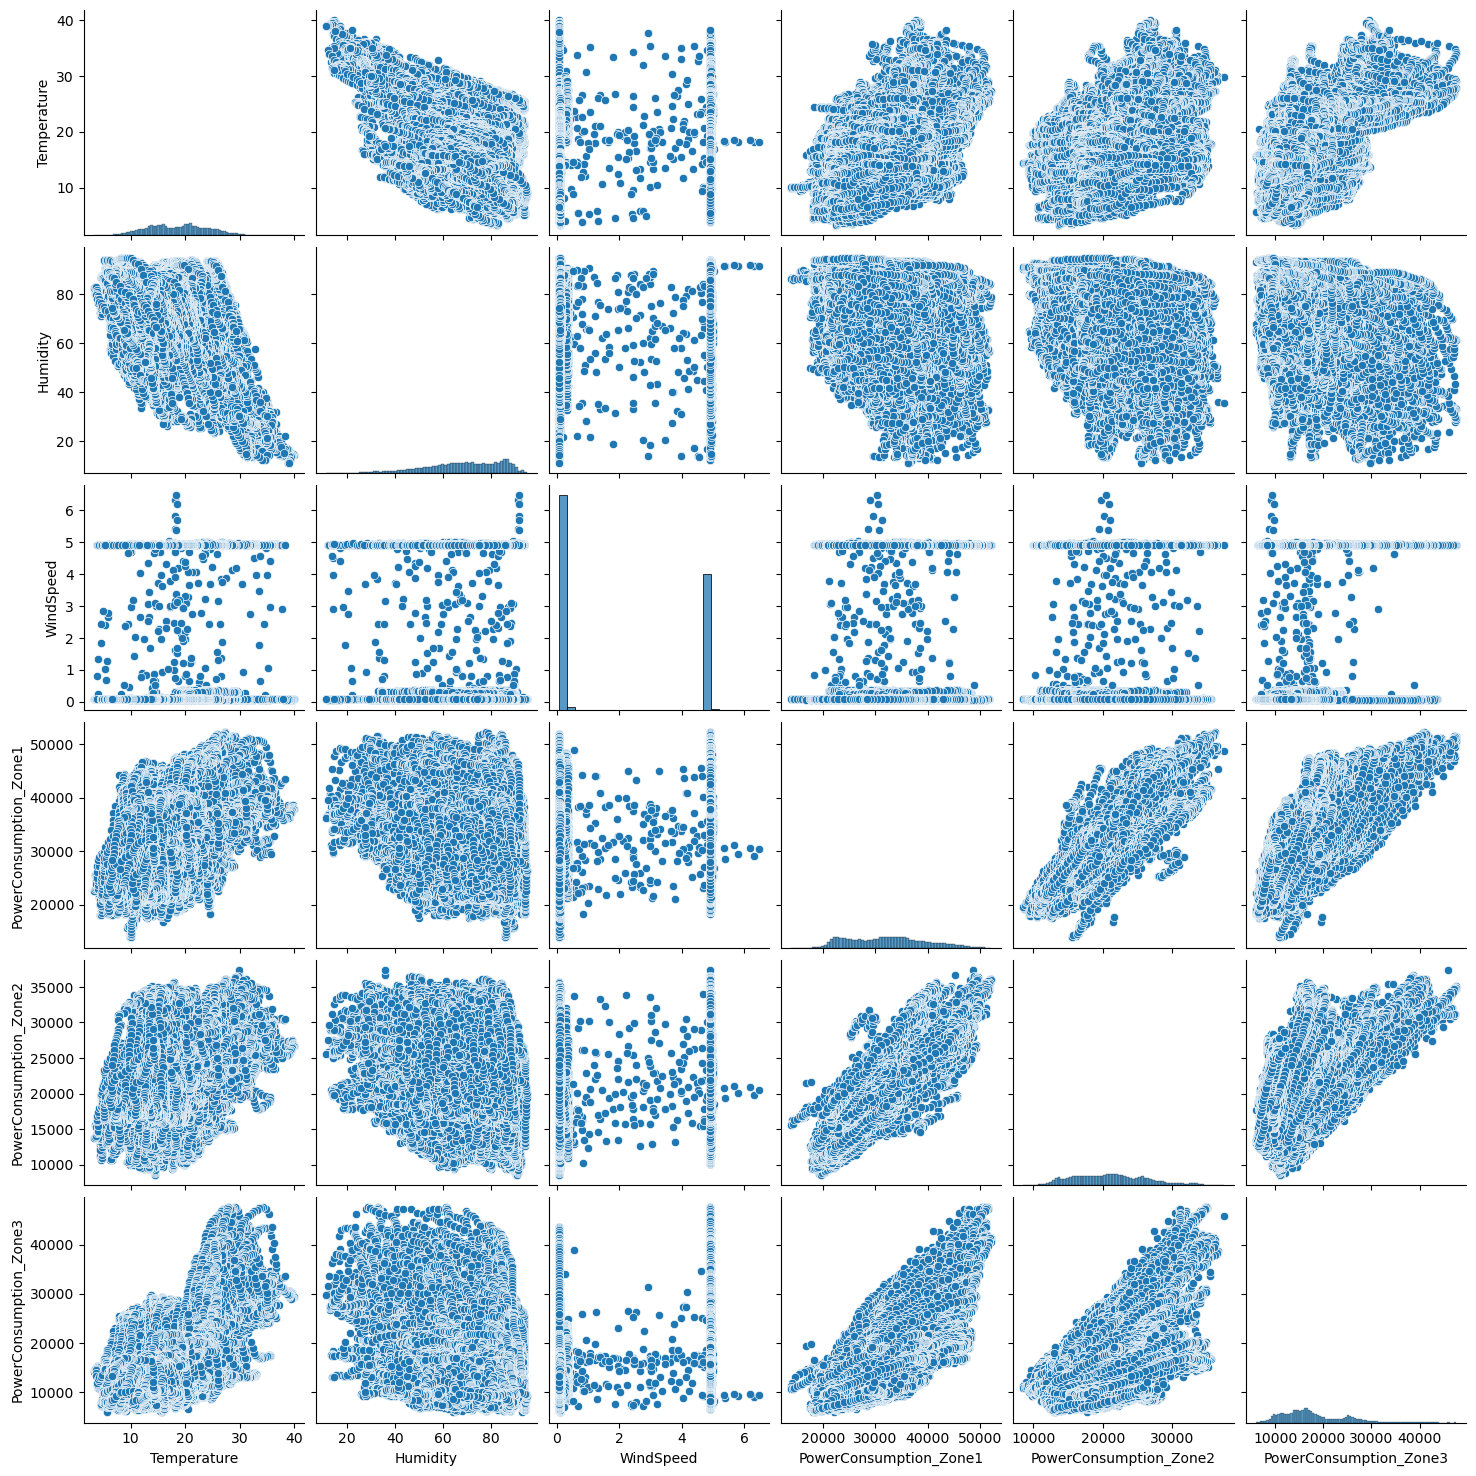

In [16]:
sns.pairplot(df[['Temperature', 'Humidity', 'WindSpeed', 'PowerConsumption_Zone1', 'PowerConsumption_Zone2', 'PowerConsumption_Zone3']])
plt.show()


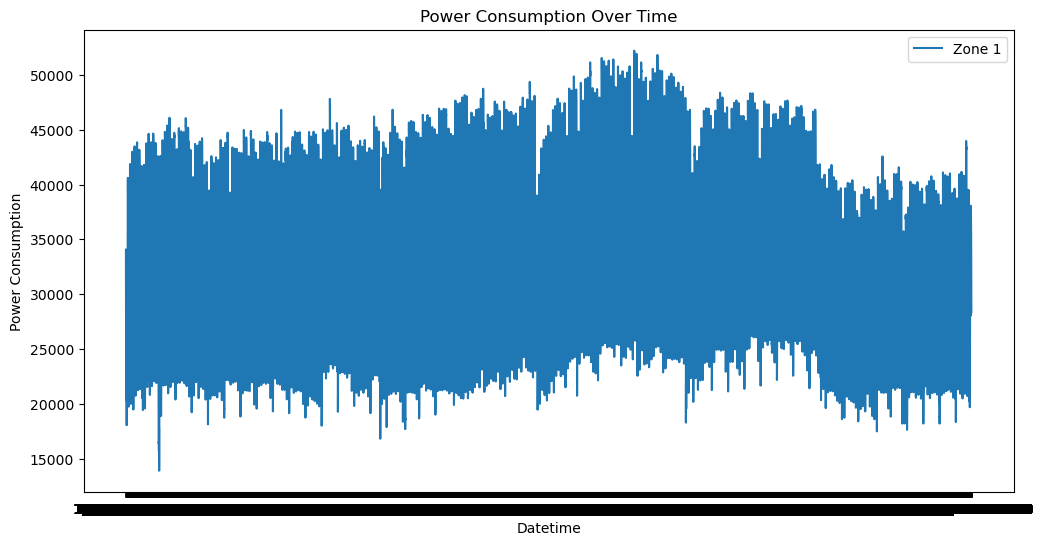

In [17]:
plt.figure(figsize=(12, 6))
sns.lineplot(x='Datetime', y='PowerConsumption_Zone1', data=df, label='Zone 1')
plt.xlabel('Datetime')
plt.ylabel('Power Consumption')
plt.title('Power Consumption Over Time')
plt.show()

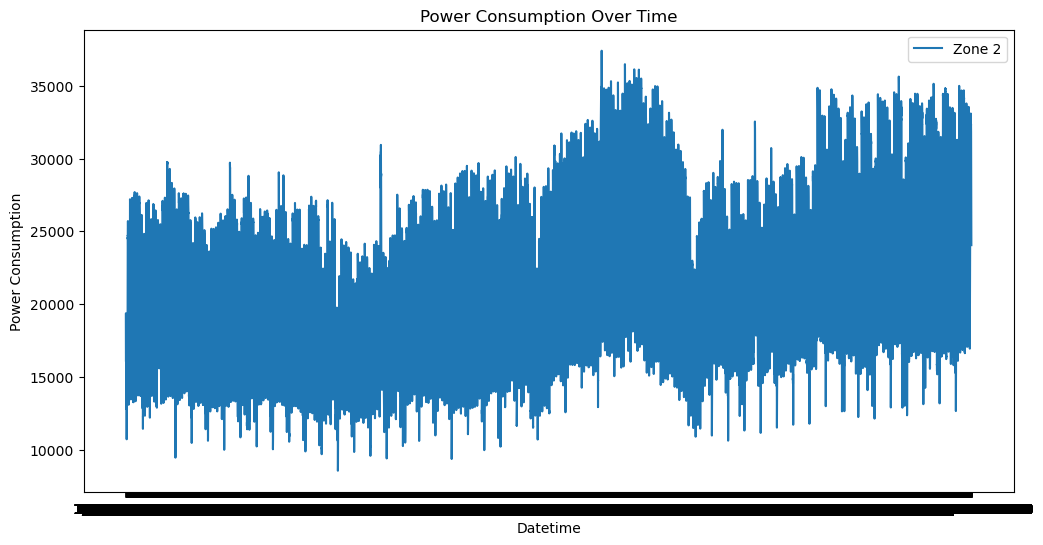

In [18]:
plt.figure(figsize=(12, 6))
sns.lineplot(x='Datetime', y='PowerConsumption_Zone2', data=df, label='Zone 2')
plt.xlabel('Datetime')
plt.ylabel('Power Consumption')
plt.title('Power Consumption Over Time')
plt.show()

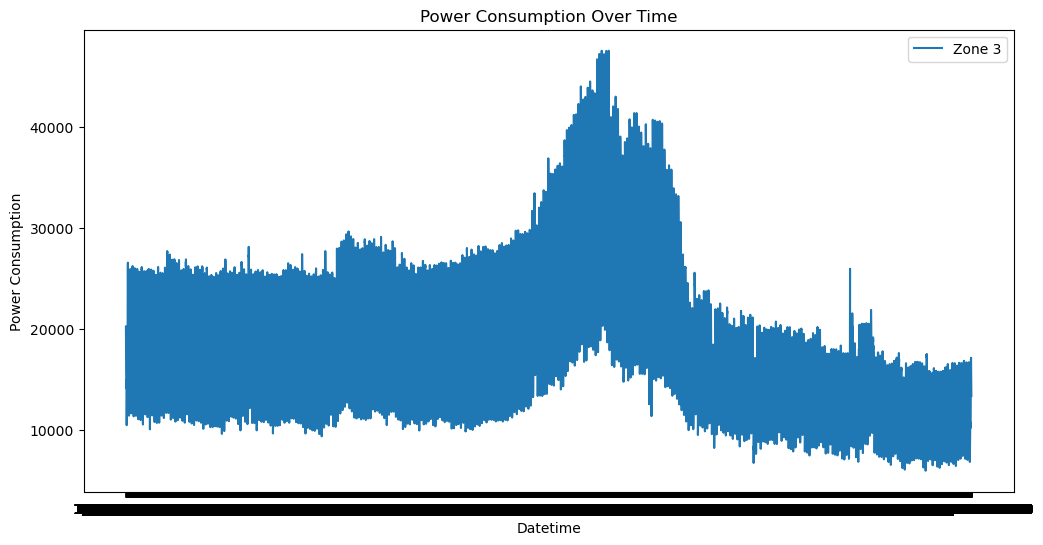

In [19]:
plt.figure(figsize=(12, 6))
sns.lineplot(x='Datetime', y='PowerConsumption_Zone3', data=df, label='Zone 3')
plt.xlabel('Datetime')
plt.ylabel('Power Consumption')
plt.title('Power Consumption Over Time')
plt.show()

# III. Data Preprocessing 

In [20]:
df['Datetime']=pd.to_datetime(df.Datetime)
df.sort_values(by='Datetime', ascending=True, inplace=True)

chronological_order = df['Datetime'].is_monotonic_increasing

time_diffs = df['Datetime'].diff()
equidistant_timestamps = time_diffs.nunique() == 1

In [21]:
chronological_order, equidistant_timestamps

(True, True)

In [22]:
df.isna().sum()

Datetime                  0
Temperature               0
Humidity                  0
WindSpeed                 0
GeneralDiffuseFlows       0
DiffuseFlows              0
PowerConsumption_Zone1    0
PowerConsumption_Zone2    0
PowerConsumption_Zone3    0
dtype: int64

# IV. Feature engineering 

In [23]:
df['TotalConsumption'] = df['PowerConsumption_Zone1'] + df['PowerConsumption_Zone2'] + df['PowerConsumption_Zone3']

In [24]:
df['year'] = df['Datetime'].apply(lambda x : x.year)
df['month'] = df['Datetime'].apply(lambda x : x.month)
df['day'] = df['Datetime'].apply(lambda x : x.day)
df['weekday'] = df['Datetime'].apply(lambda x : x.day_name())
df['weekofyear'] = df['Datetime'].apply(lambda x : x.weekofyear)
df['hour'] = df['Datetime'].apply(lambda x : x.hour)
df['minute'] = df['Datetime'].apply(lambda x : x.minute)

In [25]:
def hours2timing(x):
  if x in [22,23,0,1,2,3]:
    timing = 'Night'
  elif x in range(4, 12):
    timing = 'Morning'
  elif x in range(12, 17):
    timing = 'Afternoon'
  elif x in range(17, 22):
    timing = 'Evening'
  else:
    timing = 'X'
  return timing

In [26]:
df['timing'] = df['hour'].apply(hours2timing)
df
     

Datetime  Temperature  Humidity  WindSpeed  \
0     2017-01-01 00:00:00        6.559      73.8      0.083   
1     2017-01-01 00:10:00        6.414      74.5      0.083   
2     2017-01-01 00:20:00        6.313      74.5      0.080   
3     2017-01-01 00:30:00        6.121      75.0      0.083   
4     2017-01-01 00:40:00        5.921      75.7      0.081   
...                   ...          ...       ...        ...   
52411 2017-12-30 23:10:00        7.010      72.4      0.080   
52412 2017-12-30 23:20:00        6.947      72.6      0.082   
52413 2017-12-30 23:30:00        6.900      72.8      0.086   
52414 2017-12-30 23:40:00        6.758      73.0      0.080   
52415 2017-12-30 23:50:00        6.580      74.1      0.081   

       GeneralDiffuseFlows  DiffuseFlows  PowerConsumption_Zone1  \
0                    0.051         0.119             34055.69620   
1                    0.070         0.085             29814.68354   
2                    0.062         0.100             29128.10127   
3                    0.091         0.096             28228.86076   
4                    0.048         0.085             27335.69620   
...                    ...           ...                     ...   
52411                0.040         0.096             31160.45627   
52412                0.051         0.093             30430.41825   
52413                0.084         0.074             29590.87452   
52414                0.066         0.089             28958.17490   
52415                0.062         0.111             28349.80989   

       PowerConsumption_Zone2  PowerConsumption_Zone3  TotalConsumption  year  \
0                 16128.87538             20240.96386       70425.53544  2017   
1                 19375.07599             20131.08434       69320.84387  2017   
2                 19006.68693             19668.43373       67803.22193  2017   
3                 18361.09422             18899.27711       65489.23209  2017   
4                 17872.34043             18442.40964       63650.44627  2017   
...                       ...                     ...               ...   ...   
52411             26857.31820             14780.31212       72798.08659  2017   
52412             26124.57809             14428.81152       70983.80786  2017   
52413             25277.69254             13806.48259       68675.04965  2017   
52414             24692.23688             13512.60504       67163.01682  2017   
52415             24055.23167             13345.49820       65750.53976  2017   

       month  day   weekday  weekofyear  hour  minute timing  
0          1    1    Sunday          52     0       0  Night  
1          1    1    Sunday          52     0      10  Night  
2          1    1    Sunday          52     0      20  Night  
3          1    1    Sunday          52     0      30  Night  
4          1    1    Sunday          52     0      40  Night  
...      ...  ...       ...         ...   ...     ...    ...  
52411     12   30  Saturday          52    23      10  Night  
52412     12   30  Saturday          52    23      20  Night  
52413     12   30  Saturday          52    23      30  Night  
52414     12   30  Saturday          52    23      40  Night  
52415     12   30  Saturday          52    23      50  Night  

[52416 rows x 18 columns]

In [27]:
df = df.set_index('Datetime')

In [28]:
df['TotalConsumption'] = df['TotalConsumption'] / 1000

In [29]:
df['TotalConsumption']

Datetime
2017-01-01 00:00:00    70.425535
2017-01-01 00:10:00    69.320844
2017-01-01 00:20:00    67.803222
2017-01-01 00:30:00    65.489232
2017-01-01 00:40:00    63.650446
                         ...    
2017-12-30 23:10:00    72.798087
2017-12-30 23:20:00    70.983808
2017-12-30 23:30:00    68.675050
2017-12-30 23:40:00    67.163017
2017-12-30 23:50:00    65.750540
Name: TotalConsumption, Length: 52416, dtype: float64

# V. Exploratory Data Analysis

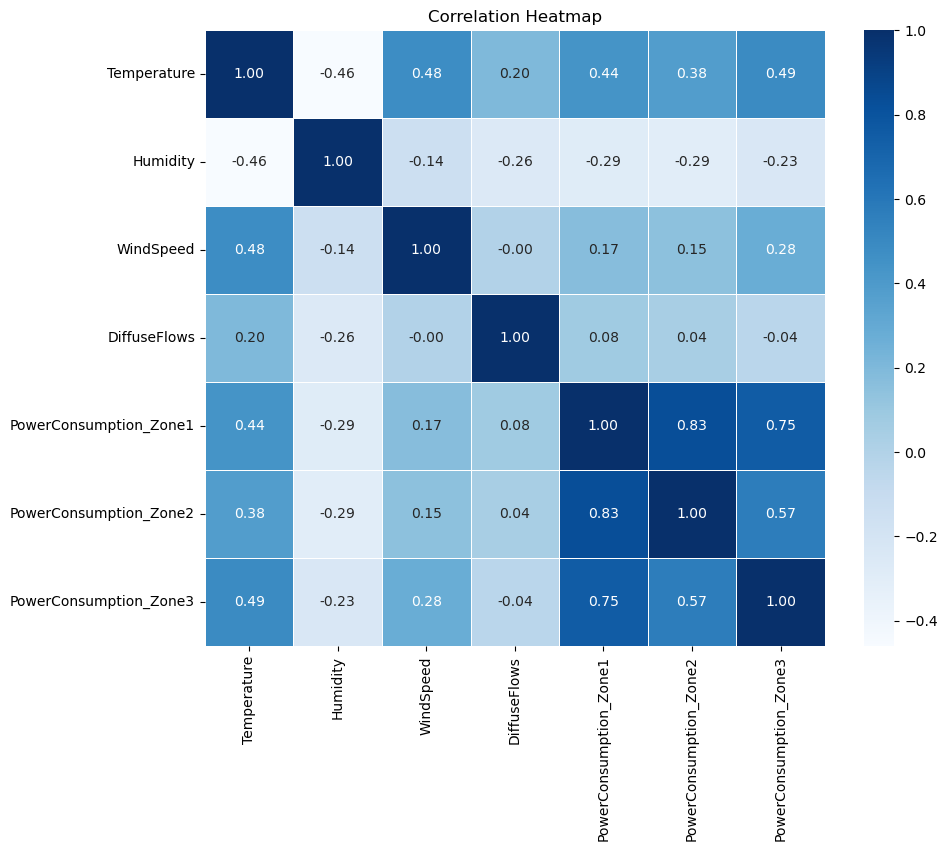

In [30]:
# Calculate correlation matrix
correlation_matrix = df[['Temperature', 'Humidity', 'WindSpeed', 'DiffuseFlows', 'PowerConsumption_Zone1', 'PowerConsumption_Zone2', 'PowerConsumption_Zone3']].corr()

# Create a heatmap of the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='Blues', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

/tmp/ipykernel_20/3899081366.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  daily_resampled = df.resample('D').mean()


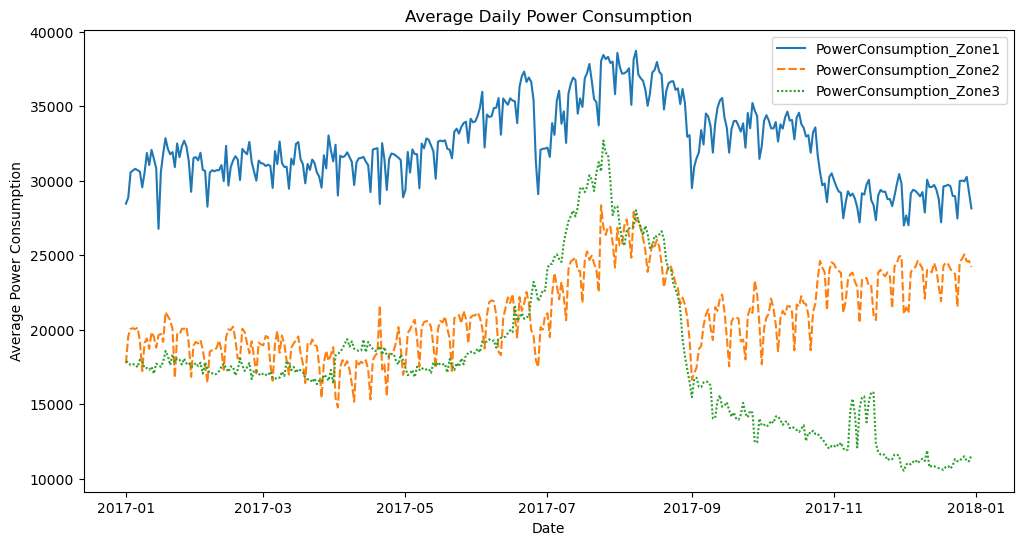

In [31]:
# Resample the data for more meaningful time series analysis 
daily_resampled = df.resample('D').mean()

# Plot daily Power Consumption for each zone
plt.figure(figsize=(12, 6))
sns.lineplot(data=daily_resampled[['PowerConsumption_Zone1', 'PowerConsumption_Zone2', 'PowerConsumption_Zone3']])
plt.xlabel('Date')
plt.ylabel('Average Power Consumption')
plt.title('Average Daily Power Consumption')
plt.legend()
plt.show()


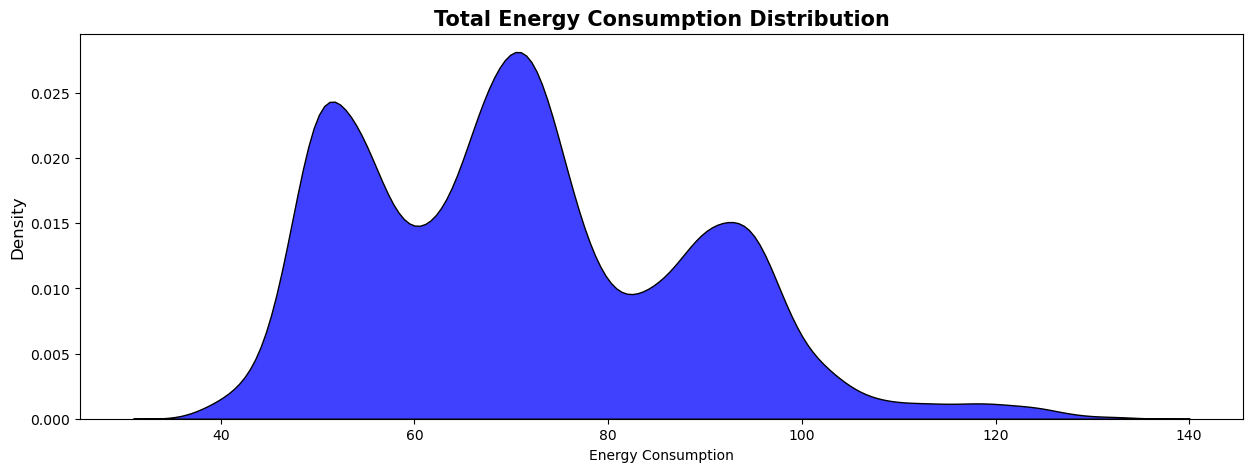

In [32]:
plt.subplots(figsize=(15,5))
sns.kdeplot(data=df, x="TotalConsumption", multiple="stack", color = 'blue')
plt.xlabel('Energy Consumption', fontsize=10)
plt.ylabel('Density', fontsize=12)
plt.title('Total Energy Consumption Distribution', fontsize=15, weight='bold')
plt.show()

In [33]:
fig = px.line(df, x=pd.date_range('2017-01-01', periods=364, freq='D'), 
              y=[df['TotalConsumption'].resample('D').mean()],
              labels={'x':'day', 'value':'mean'})
# Set title and font
fig.update_layout(title_text="Total Energy Consumption Time-Series by Day",
                  title_font_size=24,
                  title_font_family="serif",
                  title_font_color="black",
                  font_family="serif",
                  legend_title_text='Type Energy',
                  legend_borderwidth=1,
                  legend_orientation='h',
                  legend_xanchor='right',
                  legend_x=1,
                  legend_yanchor='bottom',
                  legend_y=1.02)
# Set x label
fig.update_xaxes(title_text = 'Day',
                 title_font_family="serif",
                 title_font_size=18)
# Set y label
fig.update_yaxes(title_text = 'Energy Consumption',
                 title_font_family="serif",
                 title_font_size=18)
# Rename legend
newnames = {'wide_variable_0':'Mean Energy Consumption', 
            'wide_variable_1':'Mean Energy Generation'}
fig.for_each_trace(lambda t: t.update(name = newnames[t.name],
                                      legendgroup = newnames[t.name],
                                      hovertemplate = t.hovertemplate.replace(t.name, newnames[t.name])))
fig.show()

In [34]:
fig = px.line(x=groupByMonth('TotalConsumption').index, 
              y=groupByMonth('TotalConsumption')['mean'],
              labels={'x':'month', 'value':'mean'})
# Set title and font
fig.update_layout(title_text="Total Energy Consumption Time-Series by Month",
                  title_font_size=24,
                  title_font_family="serif",
                  title_font_color="black",
                  font_family="serif",
                  legend_title_text='Type Energy',
                  legend_borderwidth=1,
                  legend_orientation='h',
                  height=600, 
                  width=1100)
# Set x label
fig.update_xaxes(title_text = 'Month',
                 title_font_family="serif",
                 title_font_size=18)
# Set y label
fig.update_yaxes(title_text = 'Energy Consumption',
                 title_font_family="serif",
                 title_font_size=18)
# Rename legend
newnames = {'wide_variable_0':'Mean Energy Consumption', 
            'wide_variable_1':'Mean Energy Generation'}
fig.show()

In [35]:

fig = px.line(x=groupByWeekday('TotalConsumption').index, 
              y=groupByWeekday('TotalConsumption')['TotalConsumption_mean'],
              labels={'x':'weekday', 'value':'mean'})
# Set title and font
fig.update_layout(title_text="Total Energy Consumption Time-Series by Weekday",
                  title_font_size=24,
                  title_font_family="serif",
                  title_font_color="black",
                  font_family="serif",
                  legend_title_text='Type Energy',
                  legend_borderwidth=1,
                  legend_orientation='h',
                  height=600, 
                  width=1100)
# Set x label
fig.update_xaxes(title_text = 'Weekday',
                 title_font_family="serif",
                 title_font_size=18)
# Set y label
fig.update_yaxes(title_text = 'Energy Consumption',
                 title_font_family="serif",
                 title_font_size=18)
# Rename legend
newnames = {'wide_variable_0':'Mean Energy Consumption', 
            'wide_variable_1':'Mean Energy Generation'}

fig.show()

In [36]:
fig = px.line(x=groupByTiming('TotalConsumption').index, 
              y=groupByTiming('TotalConsumption')['TotalConsumption_mean'],
              labels={'x':'timing', 'value':'mean'})
# Set title and font
fig.update_layout(title_text="Total Energy Consumption Time-Series by Timing",
                  title_font_size=24,
                  title_font_family="serif",
                  title_font_color="black",
                  font_family="serif",
                  legend_title_text='Type Energy',
                  legend_borderwidth=1,
                  legend_orientation='h',
                  height=600, 
                  width=1100)
# Set x label
fig.update_xaxes(title_text = 'Timing',
                 title_font_family="serif",
                 title_font_size=18)
# Set y label
fig.update_yaxes(title_text = 'Energy Consumption',
                 title_font_family="serif",
                 title_font_size=18)
# Rename legend
newnames = {'wide_variable_0':'Mean Energy Consumption', 
            'wide_variable_1':'Mean Energy Generation'}
fig.show()

In [37]:
fig = px.line(df, x=pd.date_range('2017-01-01', periods=364, freq='D'), 
              y=[df['Temperature'].resample('D').mean(),
                 df['Humidity'].resample('D').mean(),
                 df['WindSpeed'].resample('D').mean(),
                 df['DiffuseFlows'].resample('D').mean()],
              labels={'x':'day', 'value':'mean'})
# Set title and font
fig.update_layout(title_text="Weather Information Time-Series by Day",
                  title_font_size=24,
                  title_font_family="serif",
                  title_font_color="black",
                  font_family="serif",
                  legend_title_text='Weather Information',
                  legend_borderwidth=1)
# Set x label
fig.update_xaxes(title_text = 'Day',
                 title_font_family="serif",
                 title_font_size=18)
# Set y label
fig.update_yaxes(title_text = 'Values',
                 title_font_family="serif",
                 title_font_size=18)
# Rename legend
newnames = {'wide_variable_0':'Mean Temperature',
            'wide_variable_1':'Mean Humidity',
            'wide_variable_2':'Mean WindSpeed',
            'wide_variable_3':'Mean DiffuseFlows'}
fig.for_each_trace(lambda t: t.update(name = newnames[t.name],
                                      legendgroup = newnames[t.name],
                                      hovertemplate = t.hovertemplate.replace(t.name, newnames[t.name])))
fig.show()

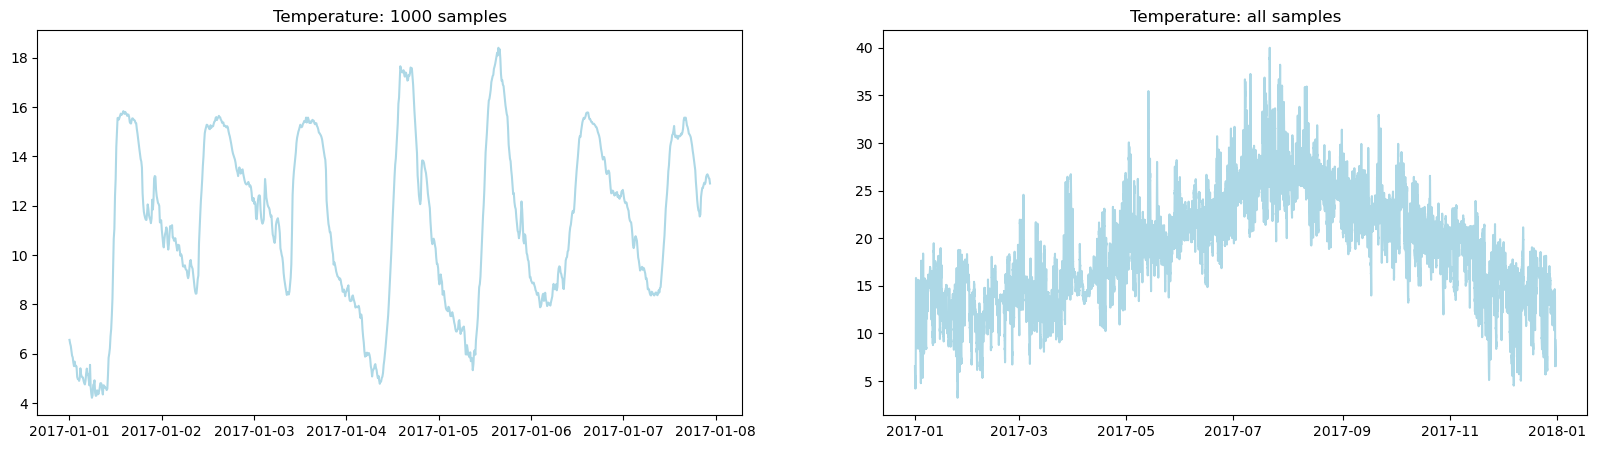

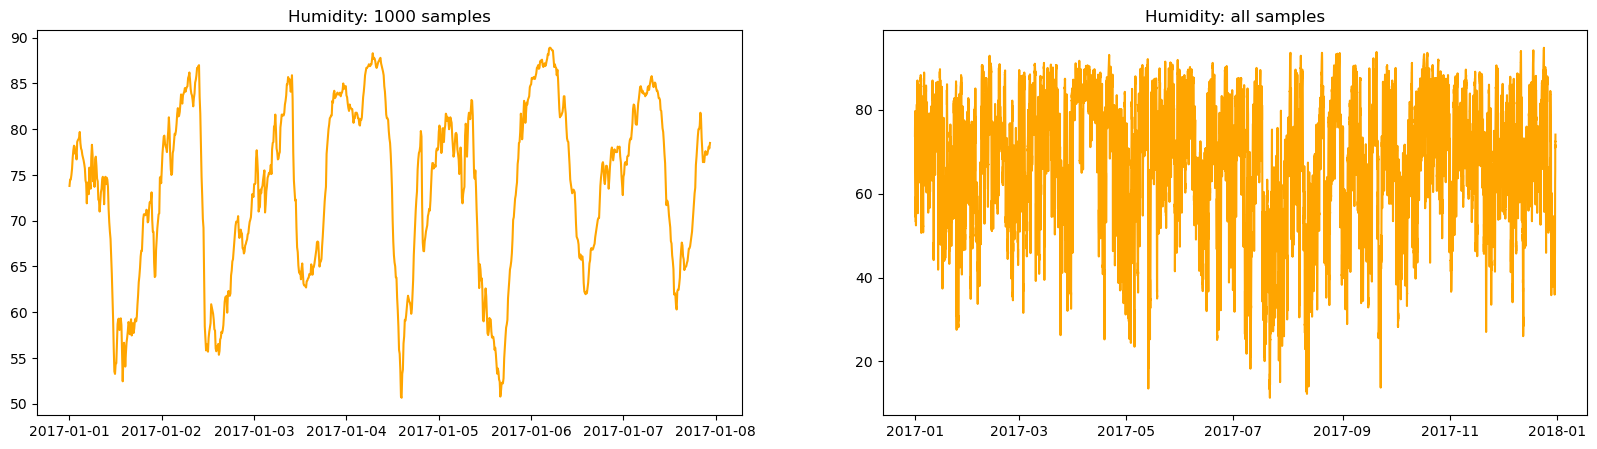

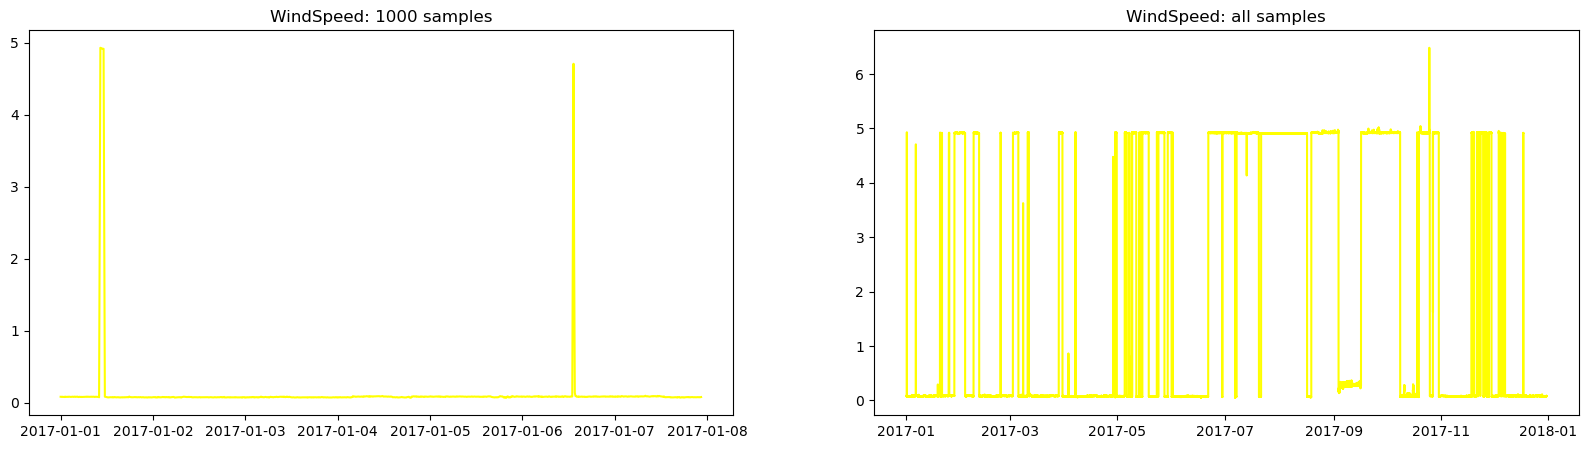

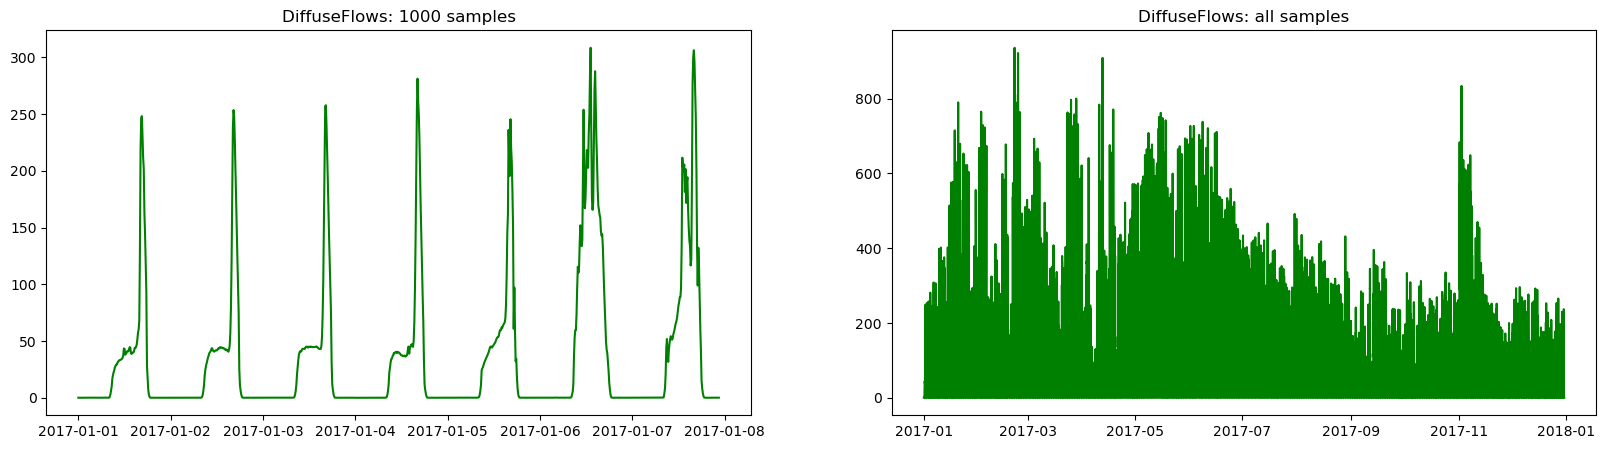

In [38]:
plot_features(df, ["Temperature", "Humidity", "WindSpeed", "DiffuseFlows"], n_samples=[1000, None])

In [39]:
labels = ['Temperature', 'Humidity', 'WindSpeed', 'DiffuseFlows']

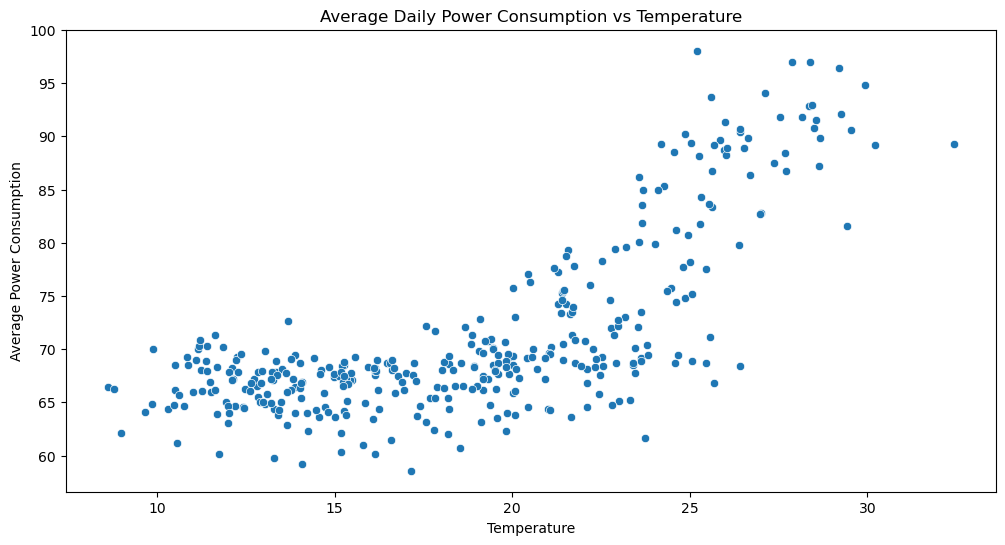

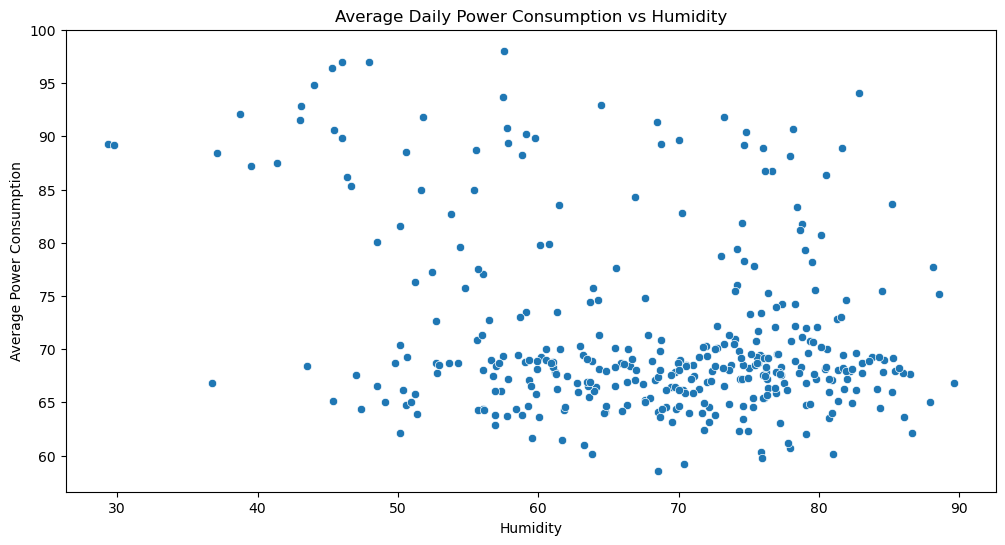

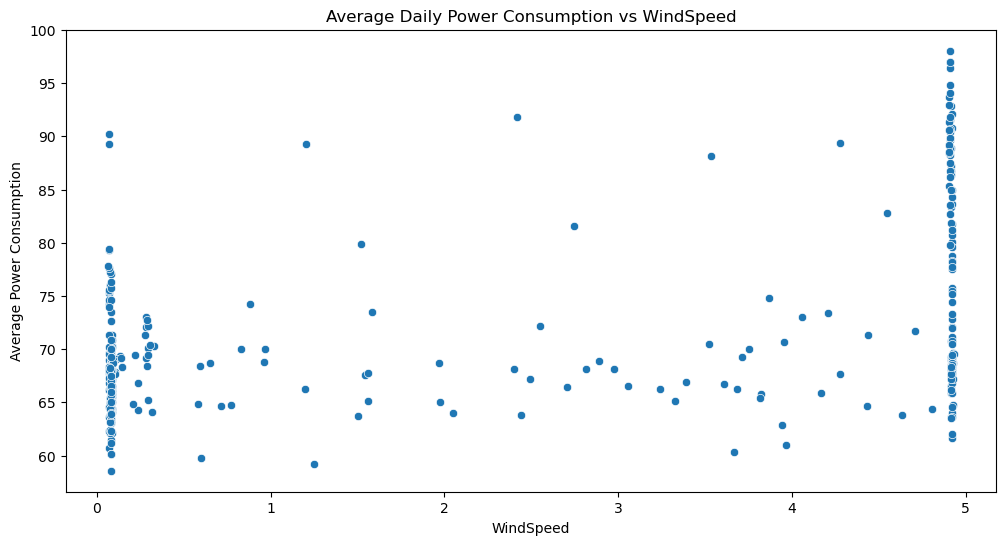

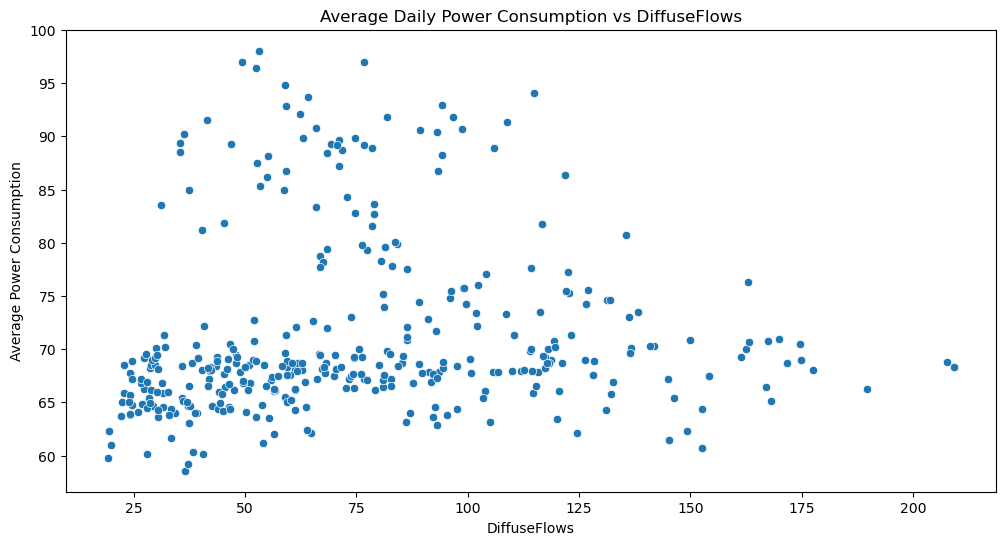

In [40]:
for label in labels:
    plt.figure(figsize=(12, 6))
    sns.scatterplot(x = daily_resampled[label],y=daily_resampled['TotalConsumption'])
    plt.xlabel(f'{label}')
    plt.ylabel('Average Power Consumption')
    plt.title(f'Average Daily Power Consumption vs {label}')
    plt.show()

# VI. Model

In [41]:
epochs = 40
batch_size = 64
WINDOW_SIZE = 30

In [42]:
Models = ['CNN', 'GRU', 'LSTM', 'BiLSTM']
Results = {}
Models = {}

In [43]:
Results['CNN'] = []
Results['GRU'] = []
Results['LSTM'] = []
Results['BiLSTM'] = []

In [44]:
Models['CNN'] = []
Models['GRU'] = []
Models['LSTM'] = []
Models['BiLSTM'] = []

In [45]:
def Model(model_name, i):
    if model_name == 'CNN':
        model = tf.keras.Sequential([
        Input(shape=(WINDOW_SIZE, i)),
        Conv1D(64, 2, activation="relu"),
        Flatten(),
        Dense(16, activation="relu"),
        Dense(1, activation="linear"),],name=model_name)
        
    elif model_name == 'GRU':
        model = tf.keras.Sequential([
        Input(shape=(WINDOW_SIZE, i)),
        GRU(64, activation = 'relu'),
        Dense(8, 'relu'),
        Dense(1, 'linear'),], name=model_name)
        
    elif model_name == 'LSTM':
        model = tf.keras.Sequential([
        Input(shape=(WINDOW_SIZE, i)),
        LSTM(64, activation = 'relu'),
        Dense(8, 'relu'),
        Dense(1, 'linear'),], name=model_name)
        
    elif model_name == 'BiLSTM':
        model = tf.keras.Sequential([
        Input(shape=(WINDOW_SIZE, i)),
        Bidirectional(LSTM(64, activation = 'relu')),
        Dense(8, 'relu'),
        Dense(1, 'linear'),], name=model_name)
    
    return model

In [46]:
def df_to_X_y(df, window_size=10):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [r for r in df_as_np[i:i+window_size]]
    X.append(row)
    label = df_as_np[i+window_size]
    y.append(label)
  return np.array(X), np.array(y)

In [47]:
def df_to_X_y2(df, window_size=10):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [r for r in df_as_np[i:i+window_size]]
    X.append(row)
    label = df_as_np[i+window_size][0]
    y.append(label)
  return np.array(X), np.array(y)

## VI.1. Univariate forecaster

In [48]:
size = len(df)
series = df['TotalConsumption']
X1, y1 = df_to_X_y(series, WINDOW_SIZE)
X1.shape, y1.shape

((52386, 30), (52386,))

In [49]:
X_train1, y_train1 = X1[:int(size*0.7)], y1[:int(size*0.7)]
X_val1, y_val1 = X1[int(size*0.7):int(size*0.8)], y1[int(size*0.7):int(size*0.8)]
X_test1, y_test1 = X1[int(size*0.8):], y1[int(size*0.8):]
X_train1.shape, y_train1.shape, X_val1.shape, y_val1.shape, X_test1.shape, y_test1.shape

((36691, 30), (36691,), (5241, 30), (5241,), (10454, 30), (10454,))

In [50]:
for model_name in Models:
    print(f'{model_name}:')
    model = Model(model_name, 1)
    
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=0.001,
        decay_steps=1000,
        decay_rate=0.9)

    model.compile(
        loss="mse",
        optimizer=Adam(learning_rate=lr_schedule),
        metrics=[RootMeanSquaredError()])
    
    callbacks = [
        ModelCheckpoint(f"{model_name}1/", save_best_only=True),
        EarlyStopping(patience=20)]
    
    history = model.fit(X_train1,y_train1,
           batch_size=batch_size,
           epochs=epochs,
           callbacks=callbacks,
           validation_data=(X_val1, y_val1))
    
    Models[f"{model_name}"].append(model)
    
    model = tf.keras.models.load_model(f"{model_name}1/")
    
    model_mse = model.evaluate(X_val1, y_val1, verbose=0)[1]
    print(f"Result on Val Set: {model_mse}")
    
    predictions = model.predict(X_test1, verbose=0)
    model_mse_test = mean_squared_error(y_test1, predictions, squared=False)
    print(f"Result on Test set: {model_mse_test}")
    
    Results[f"{model_name}"].append(model_mse_test)

CNN:
Epoch 1/40
574/574 [==============================] - 5s 6ms/step - loss: 59.4189 - root_mean_squared_error: 7.7084 - val_loss: 6.0150 - val_root_mean_squared_error: 2.4526
Epoch 2/40
574/574 [==============================] - 3s 6ms/step - loss: 5.5696 - root_mean_squared_error: 2.3600 - val_loss: 3.3837 - val_root_mean_squared_error: 1.8395
Epoch 3/40
574/574 [==============================] - 3s 5ms/step - loss: 3.3615 - root_mean_squared_error: 1.8334 - val_loss: 1.8333 - val_root_mean_squared_error: 1.3540
Epoch 4/40
574/574 [==============================] - 3s 6ms/step - loss: 2.5327 - root_mean_squared_error: 1.5914 - val_loss: 1.3585 - val_root_mean_squared_error: 1.1655
Epoch 5/40
574/574 [==============================] - 3s 5ms/step - loss: 1.9682 - root_mean_squared_error: 1.4029 - val_loss: 1.3063 - val_root_mean_squared_error: 1.1429
Epoch 6/40
574/574 [==============================] - 3s 5ms/step - loss: 1.5891 - root_mean_squared_error: 1.2606 - val_loss: 1.0065 

In [51]:
Results

{'CNN': [0.6426476929660335],
 'GRU': [0.567011806635297],
 'LSTM': [0.5995123774813385],
 'BiLSTM': [0.635697251827627]}

In [52]:
BestModel = ''
for key, value in Results.items():
    if Results[key][0] == min(Results.values())[0]:
        BestModel = key
    

In [53]:
BestModel

'GRU'

In [54]:
Results[BestModel][0]

0.567011806635297

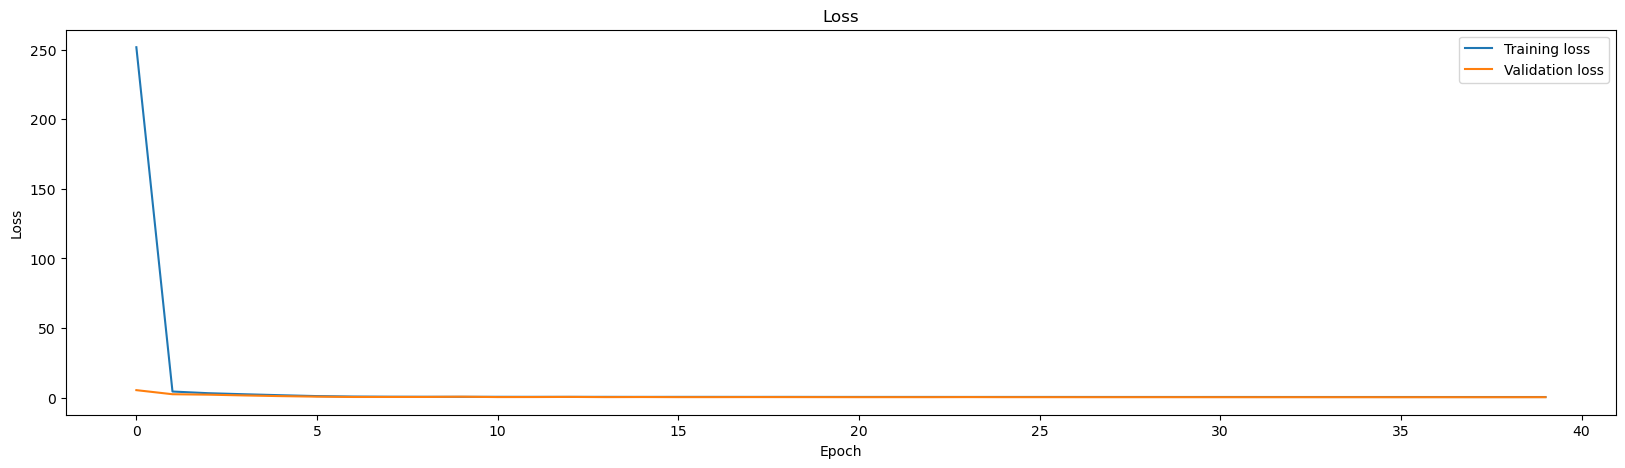

In [55]:
plot_loss(Models[BestModel][0])

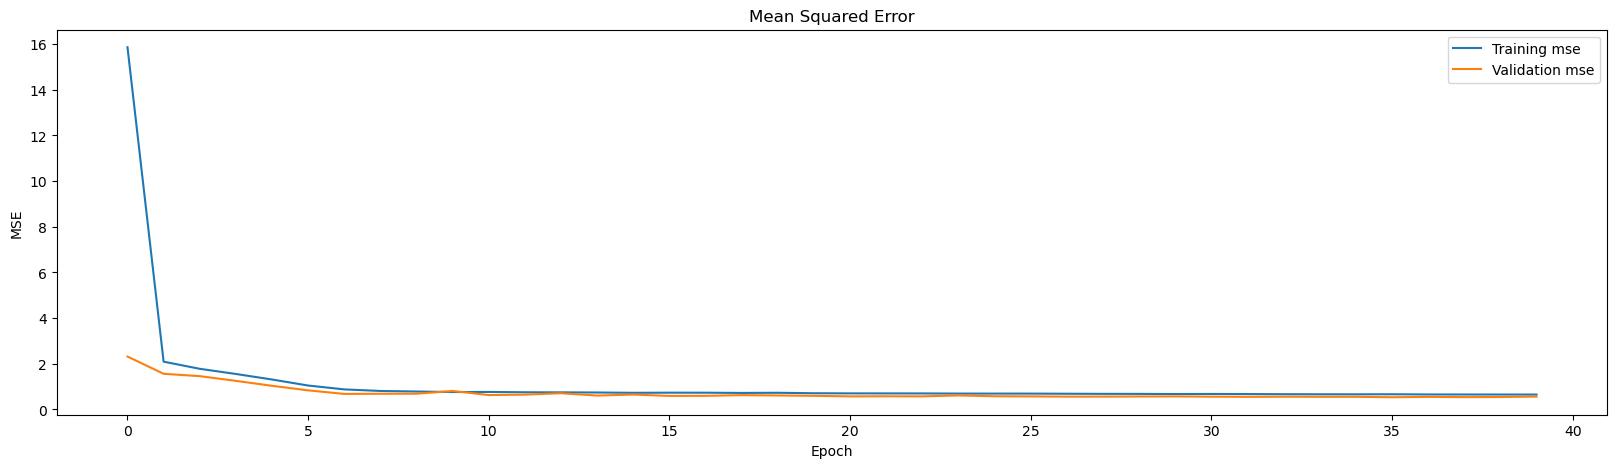

In [56]:
plot_mse(Models[BestModel][0])

In [57]:
model = tf.keras.models.load_model(f"{BestModel}1/")

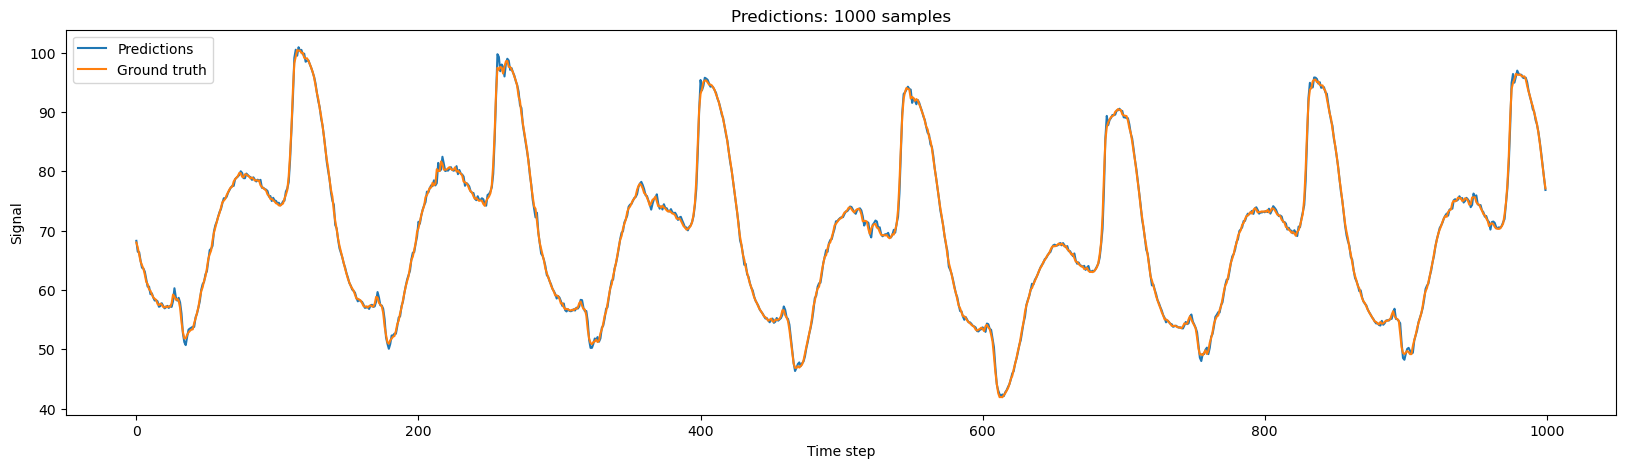

(      Predictions    Actuals
 0       68.283104  67.991039
 1       66.450737  67.151760
 2       66.373138  66.000395
 3       64.921471  64.796734
 4       63.757523  64.167338
 ...           ...        ...
 5236    61.824539  61.869486
 5237    62.774498  64.072781
 5238    65.819473  64.581425
 5239    65.343109  65.403728
 5240    66.358742  66.082263
 
 [5241 rows x 2 columns],
 0.5335912686374648)

In [58]:
plot_predictions(model, X_val1, y_val1, n_samples=1000)

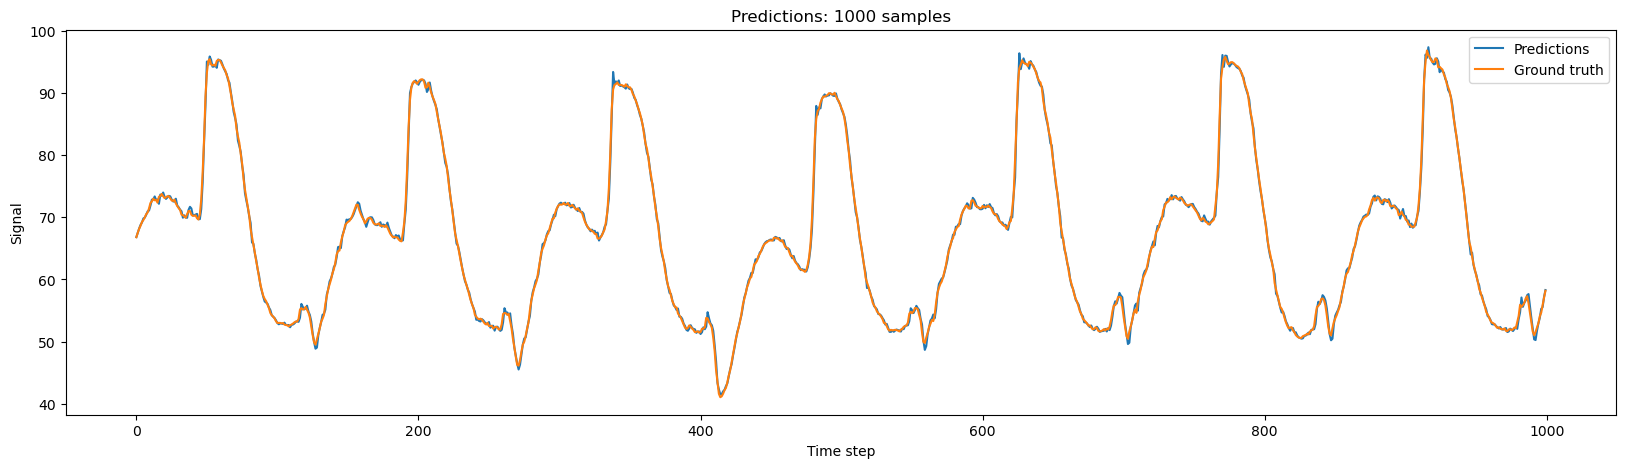

(       Predictions    Actuals
 0        66.806206  66.795333
 1        67.498604  67.517974
 2        68.196640  68.162425
 3        68.780655  68.650034
 4        69.163979  69.255505
 ...            ...        ...
 10449    73.457924  72.798087
 10450    71.386124  70.983808
 10451    69.386871  68.675050
 10452    66.667282  67.163017
 10453    65.800575  65.750540
 
 [10454 rows x 2 columns],
 0.567011806635297)

In [59]:
plot_predictions(model, X_test1, y_test1, n_samples=1000)

## VI.2 Multivariate Time Series Forecasting using [temperature]

In [60]:
temp_df = pd.DataFrame()
temp_df['TotalConsumption'] = df['TotalConsumption']
temp_df['Temperature'] = df['Temperature']

In [61]:
size = len(temp_df)
X2, y2 = df_to_X_y2(temp_df, WINDOW_SIZE)
X2.shape, y2.shape

((52386, 30, 2), (52386,))

In [62]:
X_train2, y_train2 = X2[:int(size*0.7)], y2[:int(size*0.7)]
X_val2, y_val2 = X2[int(size*0.7):int(size*0.8)], y2[int(size*0.7):int(size*0.8)]
X_test2, y_test2 = X2[int(size*0.8):], y2[int(size*0.8):]
X_train2.shape, y_train2.shape, X_val2.shape, y_val2.shape, X_test2.shape, y_test2.shape

((36691, 30, 2), (36691,), (5241, 30, 2), (5241,), (10454, 30, 2), (10454,))

In [63]:
for model_name in Models:
    print(f'{model_name}:')
    model = Model(model_name, 2)
    
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=0.001,
        decay_steps=1000,
        decay_rate=0.9)

    model.compile(
        loss="mse",
        optimizer=Adam(learning_rate=lr_schedule),
        metrics=[RootMeanSquaredError()])
    
    callbacks = [
        ModelCheckpoint(f"{model_name}2/", save_best_only=True),
        EarlyStopping(patience=20)]
    
    history = model.fit(X_train2,y_train2,
           batch_size=batch_size,
           epochs=epochs,
           callbacks=callbacks,
           validation_data=(X_val2, y_val2))
    
    Models[f"{model_name}"].append(model)
    
    model = tf.keras.models.load_model(f"{model_name}2/")
    
    model_mse = model.evaluate(X_val2, y_val2, verbose=0)[1]
    print(f"Result on Val Set: {model_mse}")
    
    predictions = model.predict(X_test2, verbose=0)
    model_mse_test = mean_squared_error(y_test2, predictions, squared=False)
    print(f"Result on Test set: {model_mse_test}")
    
    Results[f"{model_name}"].append(model_mse_test)

CNN:
Epoch 1/40
574/574 [==============================] - 4s 6ms/step - loss: 84.2778 - root_mean_squared_error: 9.1803 - val_loss: 7.0961 - val_root_mean_squared_error: 2.6638
Epoch 2/40
574/574 [==============================] - 3s 5ms/step - loss: 7.2835 - root_mean_squared_error: 2.6988 - val_loss: 4.0664 - val_root_mean_squared_error: 2.0165
Epoch 3/40
574/574 [==============================] - 3s 5ms/step - loss: 4.5727 - root_mean_squared_error: 2.1384 - val_loss: 3.6323 - val_root_mean_squared_error: 1.9059
Epoch 4/40
574/574 [==============================] - 3s 5ms/step - loss: 3.3070 - root_mean_squared_error: 1.8185 - val_loss: 3.2643 - val_root_mean_squared_error: 1.8067
Epoch 5/40
574/574 [==============================] - 3s 5ms/step - loss: 2.6143 - root_mean_squared_error: 1.6169 - val_loss: 1.6635 - val_root_mean_squared_error: 1.2898
Epoch 6/40
574/574 [==============================] - 3s 6ms/step - loss: 2.1802 - root_mean_squared_error: 1.4765 - val_loss: 1.5651 

In [64]:
Results

{'CNN': [0.6426476929660335, 0.678263454291954],
 'GRU': [0.567011806635297, 0.6043199124468875],
 'LSTM': [0.5995123774813385, 0.608078921472704],
 'BiLSTM': [0.635697251827627, 0.5483732613450327]}

In [65]:
BestModel = ''
for key, value in Results.items():
    if Results[key][1] == min(Results.values())[1]:
        BestModel = key

print(BestModel)

GRU


In [66]:
Results[BestModel][1]

0.6043199124468875

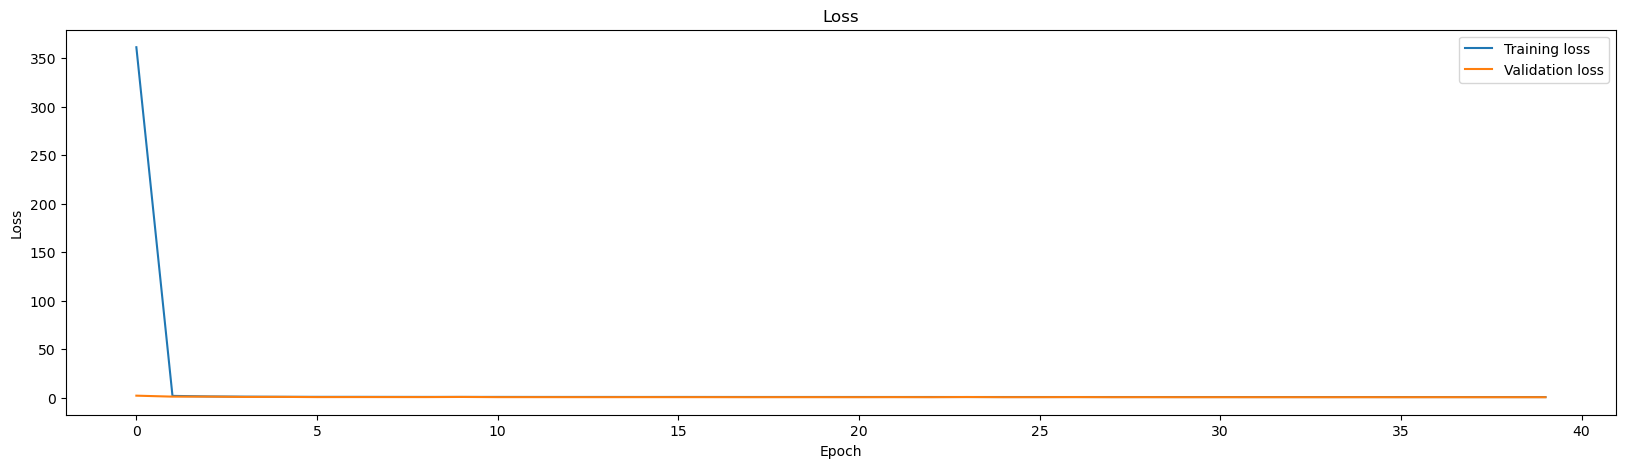

In [67]:
plot_loss(Models[BestModel][1])

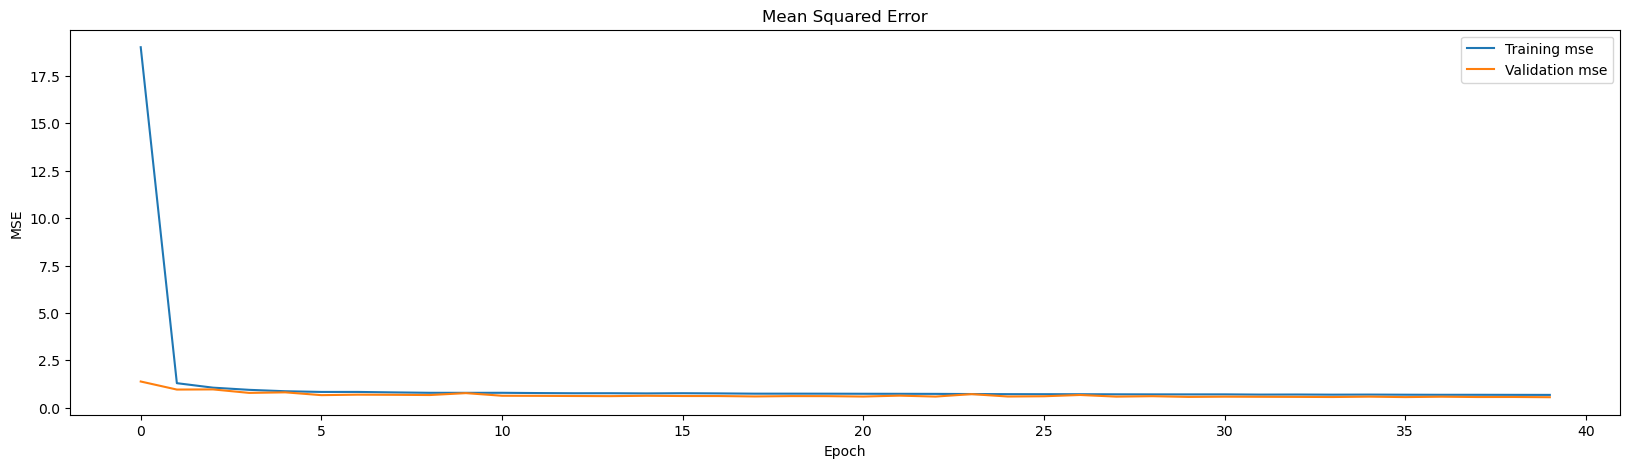

In [68]:
plot_mse(Models[BestModel][1])

In [69]:
model = tf.keras.models.load_model(f"{BestModel}2/")

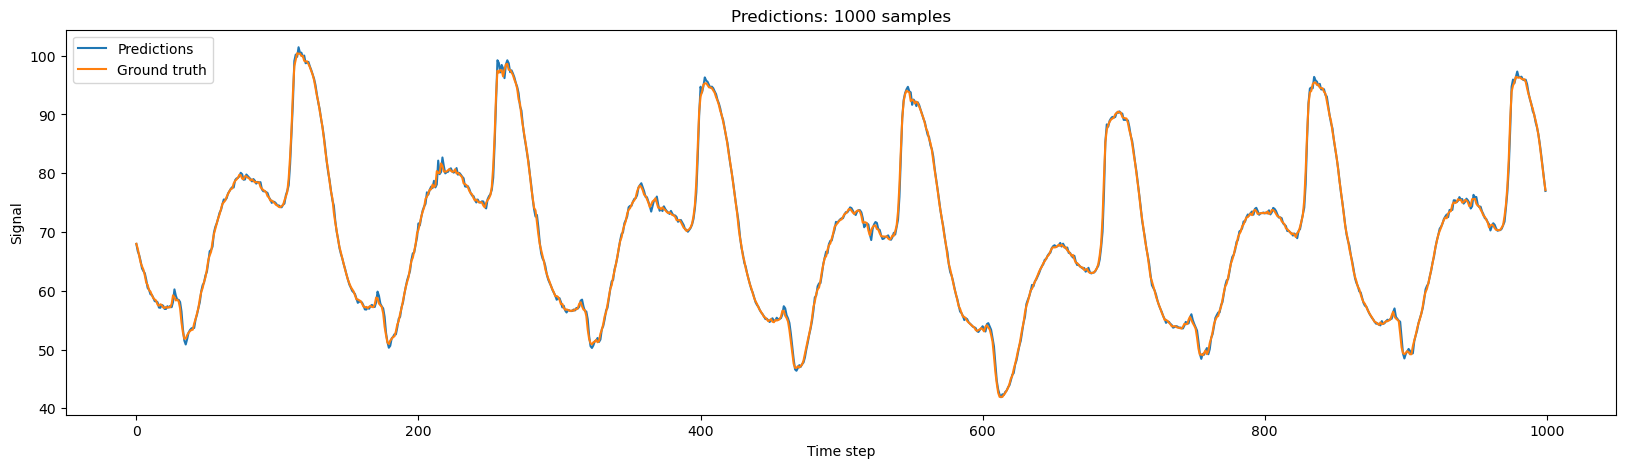

(      Predictions    Actuals
 0       67.967911  67.991039
 1       66.724838  67.151760
 2       66.070274  66.000395
 3       65.083374  64.796734
 4       63.799286  64.167338
 ...           ...        ...
 5236    61.811909  61.869486
 5237    62.753616  64.072781
 5238    65.837212  64.581425
 5239    65.287025  65.403728
 5240    66.356239  66.082263
 
 [5241 rows x 2 columns],
 0.5549514052224076)

In [70]:
plot_predictions(model, X_val2, y_val2, n_samples=1000)

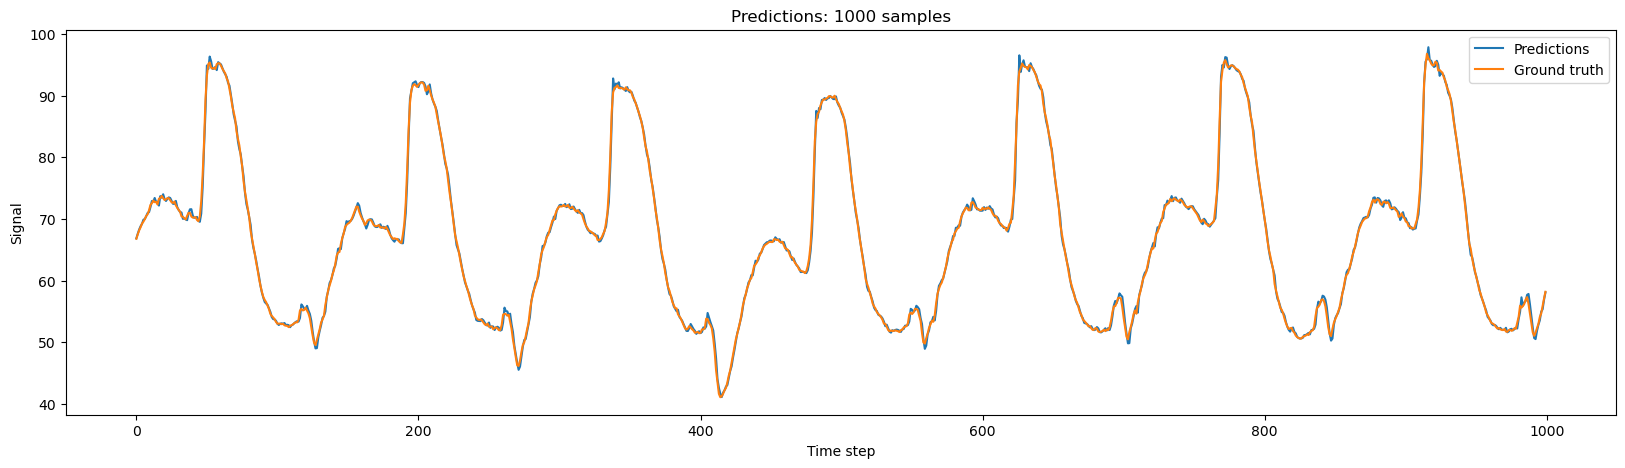

(       Predictions    Actuals
 0        66.857841  66.795333
 1        67.608658  67.517974
 2        68.290504  68.162425
 3        68.826347  68.650034
 4        69.210808  69.255505
 ...            ...        ...
 10449    73.199654  72.798087
 10450    71.439857  70.983808
 10451    69.358688  68.675050
 10452    66.809715  67.163017
 10453    65.205849  65.750540
 
 [10454 rows x 2 columns],
 0.6043199124468875)

In [71]:
plot_predictions(model, X_test2, y_test2, n_samples=1000)

## VI.3. Multivariate Time Series Forecasting using [temperature, humidity]

In [72]:
temp_df = pd.DataFrame()
temp_df['TotalConsumption'] = df['TotalConsumption']
temp_df['Temperature'] = df['Temperature']
temp_df['Humidity'] = df['Humidity']

In [73]:
size = len(temp_df)
X3, y3 = df_to_X_y2(temp_df, WINDOW_SIZE)
X3.shape, y3.shape

((52386, 30, 3), (52386,))

In [74]:
X_train3, y_train3 = X3[:int(size*0.7)], y3[:int(size*0.7)]
X_val3, y_val3 = X3[int(size*0.7):int(size*0.8)], y3[int(size*0.7):int(size*0.8)]
X_test3, y_test3 = X3[int(size*0.8):], y3[int(size*0.8):]
X_train3.shape, y_train3.shape, X_val3.shape, y_val3.shape, X_test3.shape, y_test3.shape

((36691, 30, 3), (36691,), (5241, 30, 3), (5241,), (10454, 30, 3), (10454,))

In [75]:
for model_name in Models:
    print(f'{model_name}:')
    model = Model(model_name, 3)
    
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=0.001,
        decay_steps=1000,
        decay_rate=0.9)

    model.compile(
        loss="mse",
        optimizer=Adam(learning_rate=lr_schedule),
        metrics=[RootMeanSquaredError()])
    
    callbacks = [
        ModelCheckpoint(f"{model_name}3/", save_best_only=True),
        EarlyStopping(patience=20)]
    
    history = model.fit(X_train3,y_train3,
           batch_size=batch_size,
           epochs=epochs,
           callbacks=callbacks,
           validation_data=(X_val3, y_val3))
    
    Models[f"{model_name}"].append(model)
    
    model = tf.keras.models.load_model(f"{model_name}3/")
    
    model_mse = model.evaluate(X_val3, y_val3, verbose=0)[1]
    print(f"Result on Val Set: {model_mse}")
    
    predictions = model.predict(X_test3, verbose=0)
    model_mse_test = mean_squared_error(y_test3, predictions, squared=False)
    print(f"Result on Test set: {model_mse_test}")
    
    Results[f"{model_name}"].append(model_mse_test)

CNN:
Epoch 1/40
574/574 [==============================] - 4s 6ms/step - loss: 33.3223 - root_mean_squared_error: 5.7725 - val_loss: 4.4532 - val_root_mean_squared_error: 2.1103
Epoch 2/40
574/574 [==============================] - 4s 6ms/step - loss: 4.7879 - root_mean_squared_error: 2.1881 - val_loss: 3.2507 - val_root_mean_squared_error: 1.8030
Epoch 3/40
574/574 [==============================] - 4s 7ms/step - loss: 3.3768 - root_mean_squared_error: 1.8376 - val_loss: 2.2408 - val_root_mean_squared_error: 1.4969
Epoch 4/40
574/574 [==============================] - 3s 5ms/step - loss: 2.7550 - root_mean_squared_error: 1.6598 - val_loss: 3.5008 - val_root_mean_squared_error: 1.8710
Epoch 5/40
574/574 [==============================] - 4s 6ms/step - loss: 2.0910 - root_mean_squared_error: 1.4460 - val_loss: 1.9489 - val_root_mean_squared_error: 1.3960
Epoch 6/40
574/574 [==============================] - 3s 5ms/step - loss: 1.8637 - root_mean_squared_error: 1.3652 - val_loss: 3.1152 

In [76]:
Results

{'CNN': [0.6426476929660335, 0.678263454291954, 0.6449987244732827],
 'GRU': [0.567011806635297, 0.6043199124468875, 0.593136687741093],
 'LSTM': [0.5995123774813385, 0.608078921472704, 1.2500203214475163],
 'BiLSTM': [0.635697251827627, 0.5483732613450327, 0.5946678802477354]}

In [77]:
BestModel = ''
for key, value in Results.items():
    if Results[key][2] == min(Results.values())[2]:
        BestModel = key

print(BestModel)

GRU


In [78]:
Results[BestModel][2]

0.593136687741093

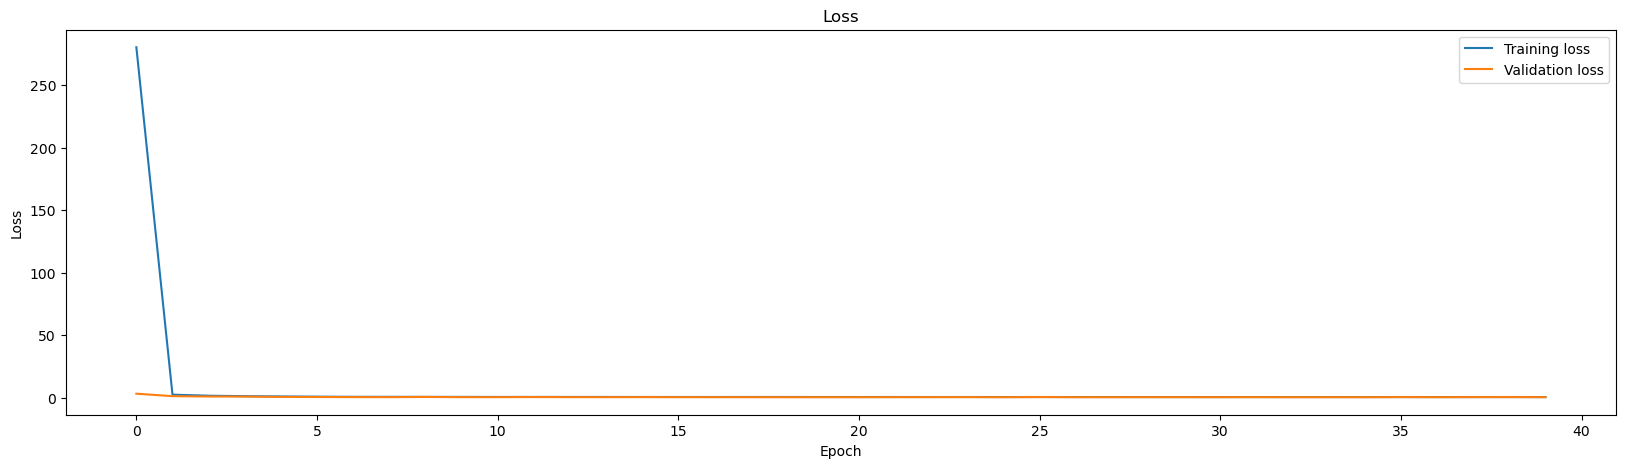

In [79]:
plot_loss(Models[BestModel][2])

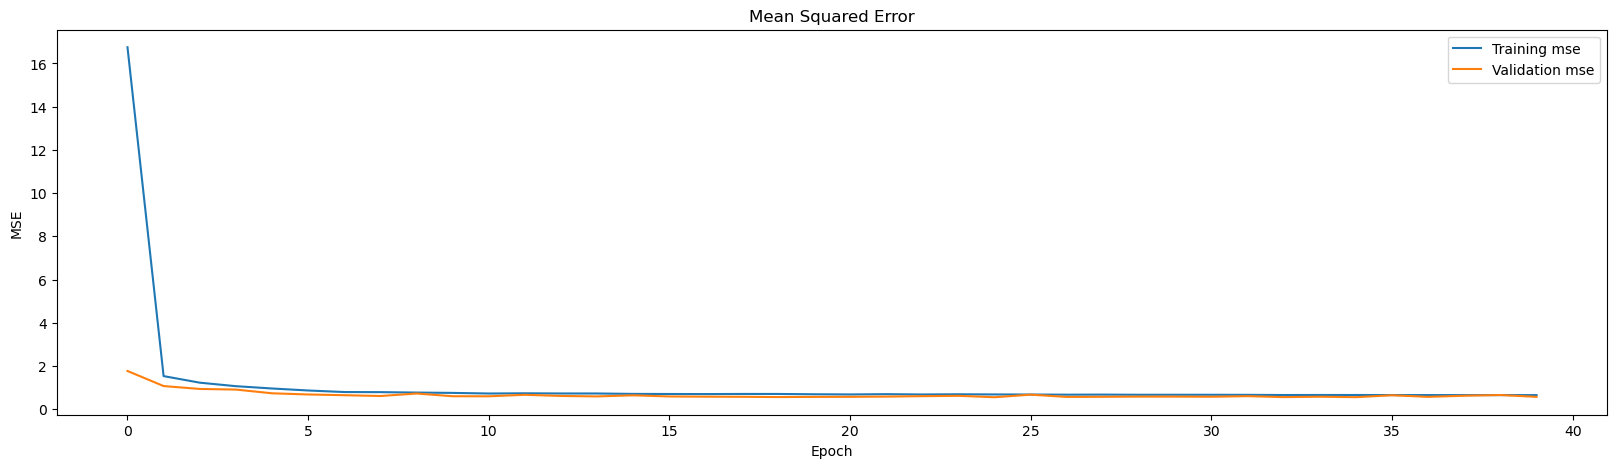

In [80]:
plot_mse(Models[BestModel][2])

In [81]:
model = tf.keras.models.load_model(f"{BestModel}3/")

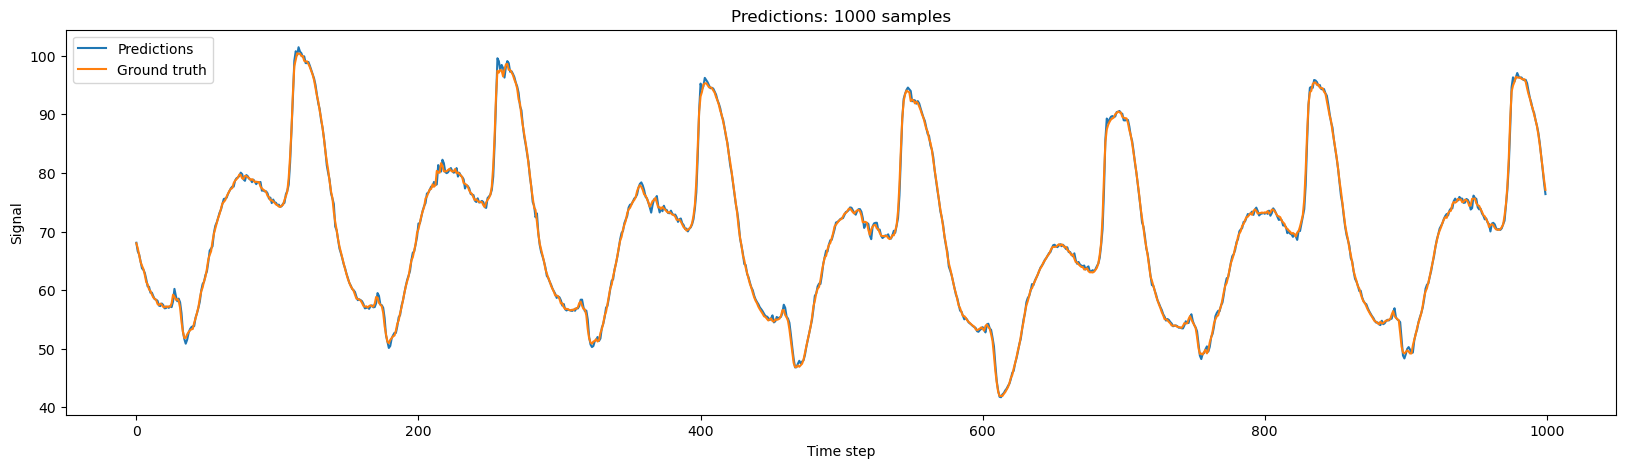

(      Predictions    Actuals
 0       68.088959  67.991039
 1       66.616562  67.151760
 2       66.079178  66.000395
 3       64.934357  64.796734
 4       63.725887  64.167338
 ...           ...        ...
 5236    61.602951  61.869486
 5237    62.643406  64.072781
 5238    65.671761  64.581425
 5239    65.441254  65.403728
 5240    66.119041  66.082263
 
 [5241 rows x 2 columns],
 0.557621714000529)

In [82]:
plot_predictions(model, X_val3, y_val3, n_samples=1000)

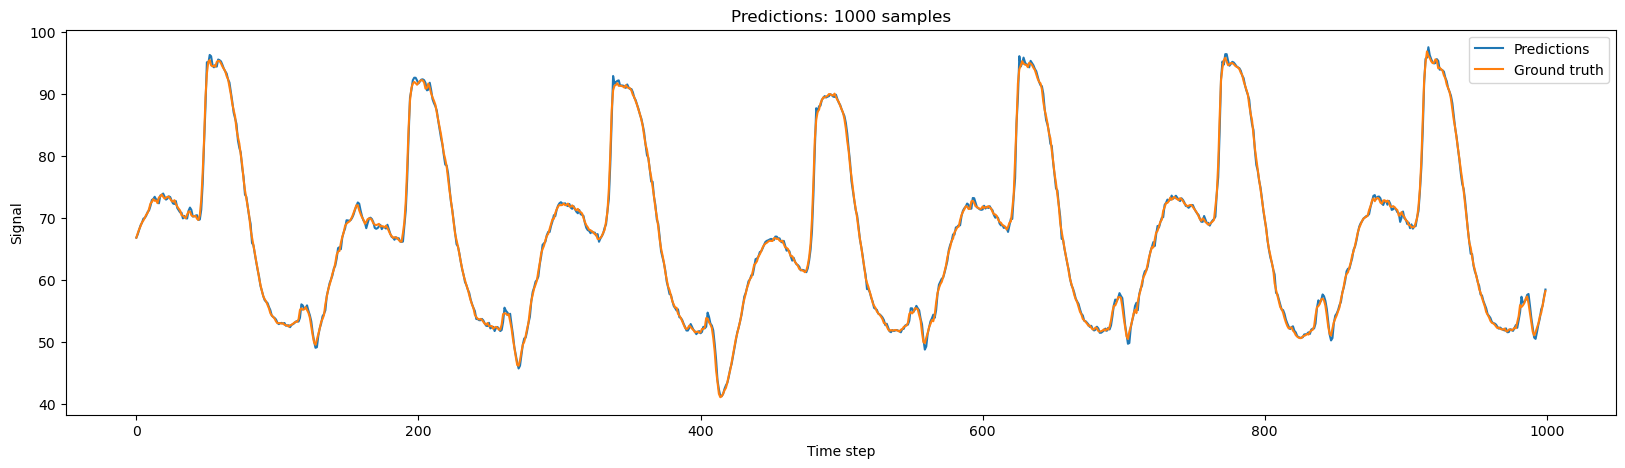

(       Predictions    Actuals
 0        66.791595  66.795333
 1        67.341446  67.517974
 2        68.085709  68.162425
 3        68.791328  68.650034
 4        69.191536  69.255505
 ...            ...        ...
 10449    73.252510  72.798087
 10450    71.142593  70.983808
 10451    69.311470  68.675050
 10452    66.499870  67.163017
 10453    65.574280  65.750540
 
 [10454 rows x 2 columns],
 0.593136687741093)

In [83]:
plot_predictions(model, X_test3, y_test3, n_samples=1000)

### VI.4. Multivariate Time Series Forecasting using [temperature, humidity, windSpeed]

In [84]:
temp_df = pd.DataFrame()
temp_df['TotalConsumption'] = df['TotalConsumption']
temp_df['Temperature'] = df['Temperature']
temp_df['Humidity'] = df['Humidity']
temp_df['WindSpeed'] = df['WindSpeed']

In [85]:
size = len(temp_df)
X4, y4 = df_to_X_y2(temp_df, WINDOW_SIZE)
X4.shape, y4.shape

((52386, 30, 4), (52386,))

In [86]:
X_train4, y_train4 = X4[:int(size*0.7)], y4[:int(size*0.7)]
X_val4, y_val4 = X4[int(size*0.7):int(size*0.8)], y4[int(size*0.7):int(size*0.8)]
X_test4, y_test4 = X4[int(size*0.8):], y4[int(size*0.8):]
X_train4.shape, y_train4.shape, X_val4.shape, y_val4.shape, X_test4.shape, y_test4.shape

((36691, 30, 4), (36691,), (5241, 30, 4), (5241,), (10454, 30, 4), (10454,))

In [87]:
for model_name in Models:
    print(f'{model_name}:')
    model = Model(model_name, 4)
    
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=0.001,
        decay_steps=1000,
        decay_rate=0.9)

    model.compile(
        loss="mse",
        optimizer=Adam(learning_rate=lr_schedule),
        metrics=[RootMeanSquaredError()])
    
    callbacks = [
        ModelCheckpoint(f"{model_name}4/", save_best_only=True),
        EarlyStopping(patience=20)]
    
    history = model.fit(X_train4,y_train4,
           batch_size=batch_size,
           epochs=epochs,
           callbacks=callbacks,
           validation_data=(X_val4, y_val4))
    
    Models[f"{model_name}"].append(model)
    
    model = tf.keras.models.load_model(f"{model_name}4/")
    
    model_mse = model.evaluate(X_val4, y_val4, verbose=0)[1]
    print(f"Result on Val Set: {model_mse}")
    
    predictions = model.predict(X_test4, verbose=0)
    model_mse_test = mean_squared_error(y_test4, predictions, squared=False)
    print(f"Result on Test set: {model_mse_test}")
    
    Results[f"{model_name}"].append(model_mse_test)

CNN:
Epoch 1/40
574/574 [==============================] - 5s 6ms/step - loss: 61.4227 - root_mean_squared_error: 7.8373 - val_loss: 7.3081 - val_root_mean_squared_error: 2.7033
Epoch 2/40
574/574 [==============================] - 3s 6ms/step - loss: 5.8806 - root_mean_squared_error: 2.4250 - val_loss: 4.2178 - val_root_mean_squared_error: 2.0537
Epoch 3/40
574/574 [==============================] - 3s 6ms/step - loss: 4.2835 - root_mean_squared_error: 2.0697 - val_loss: 2.9661 - val_root_mean_squared_error: 1.7222
Epoch 4/40
574/574 [==============================] - 4s 6ms/step - loss: 3.3330 - root_mean_squared_error: 1.8257 - val_loss: 2.4809 - val_root_mean_squared_error: 1.5751
Epoch 5/40
574/574 [==============================] - 2s 4ms/step - loss: 2.8964 - root_mean_squared_error: 1.7019 - val_loss: 3.4791 - val_root_mean_squared_error: 1.8652
Epoch 6/40
574/574 [==============================] - 3s 6ms/step - loss: 2.5186 - root_mean_squared_error: 1.5870 - val_loss: 1.8250 

In [88]:
BestModel = ''
for key, value in Results.items():
    if Results[key][3] == min(Results.values())[3]:
        BestModel = key

print(BestModel)

GRU


In [89]:
Results[BestModel][3]

0.5716389808666479

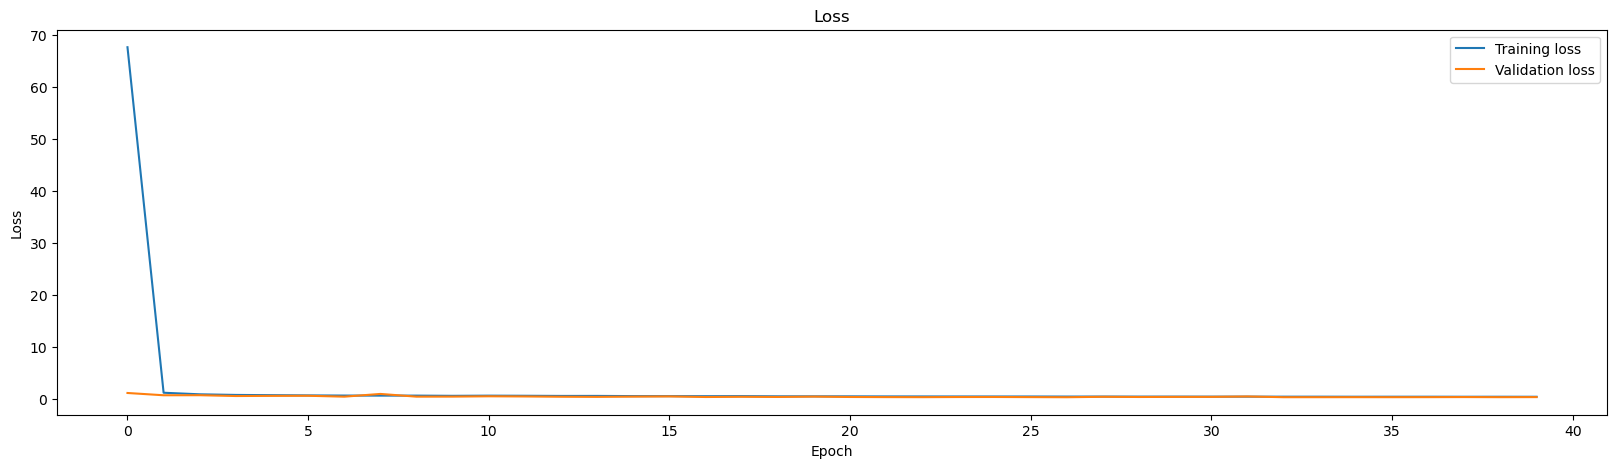

In [90]:
plot_loss(Models[BestModel][3])

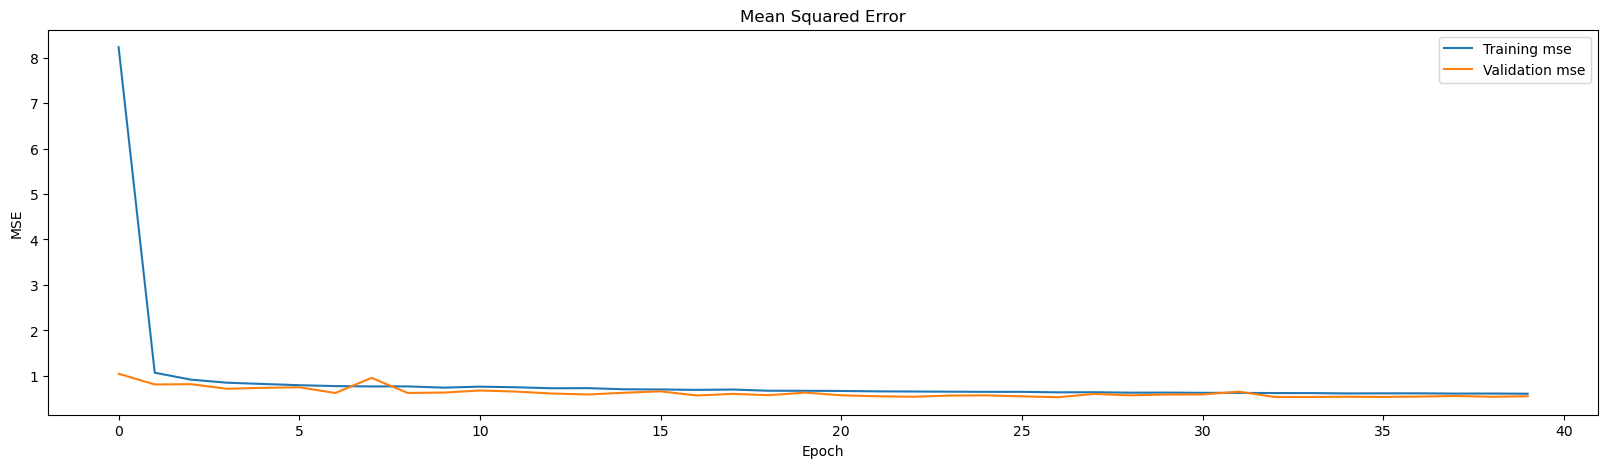

In [91]:
plot_mse(Models[BestModel][3])

In [92]:
model = tf.keras.models.load_model(f"{BestModel}4/")

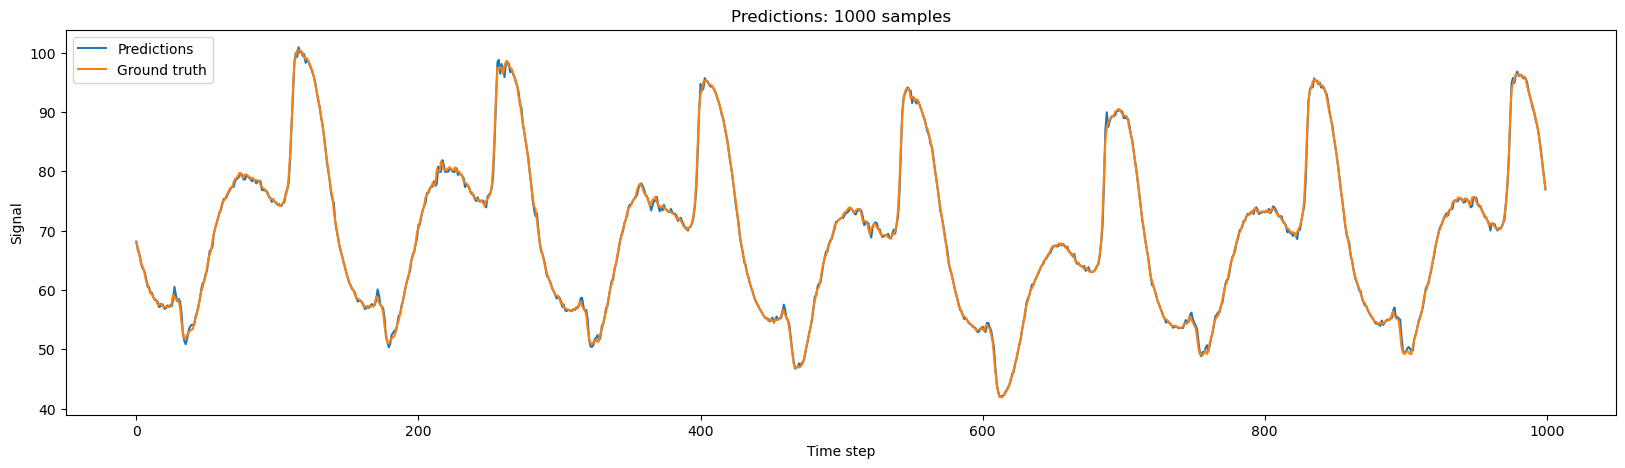

(      Predictions    Actuals
 0       68.159058  67.991039
 1       66.752602  67.151760
 2       66.228264  66.000395
 3       65.040840  64.796734
 4       63.875553  64.167338
 ...           ...        ...
 5236    61.751942  61.869486
 5237    62.662518  64.072781
 5238    65.591431  64.581425
 5239    65.248817  65.403728
 5240    66.247322  66.082263
 
 [5241 rows x 2 columns],
 0.5314732309039845)

In [93]:
plot_predictions(model, X_val4, y_val4, n_samples=1000)

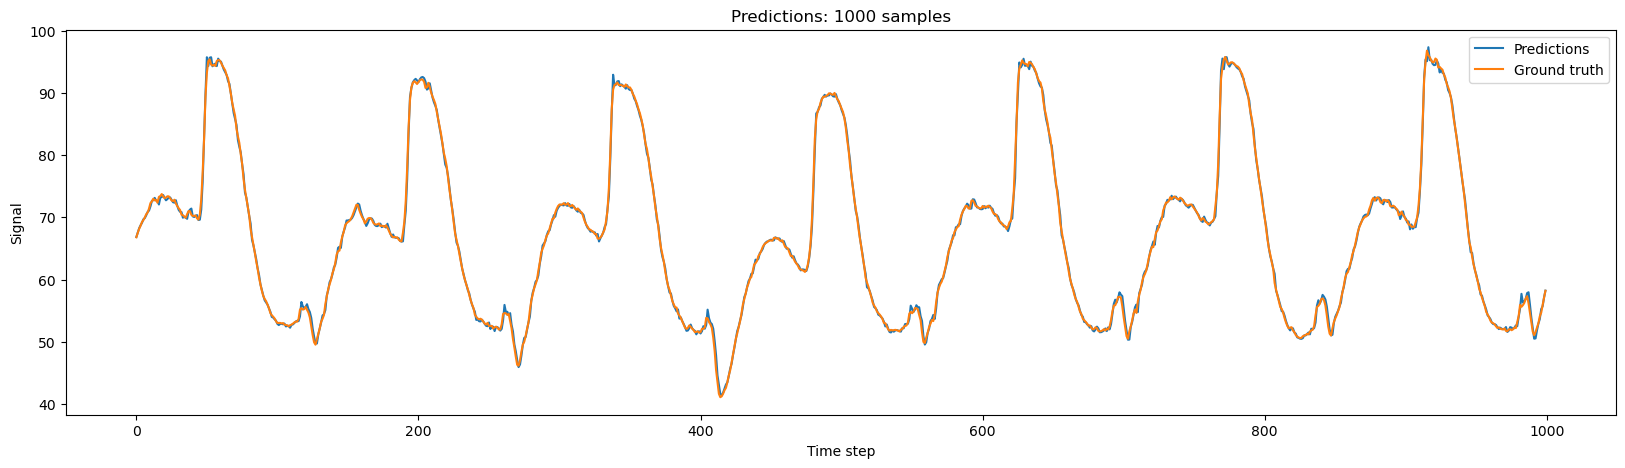

(       Predictions    Actuals
 0        66.833221  66.795333
 1        67.537170  67.517974
 2        68.253166  68.162425
 3        68.724838  68.650034
 4        69.115501  69.255505
 ...            ...        ...
 10449    73.053612  72.798087
 10450    71.215790  70.983808
 10451    69.182594  68.675050
 10452    66.629692  67.163017
 10453    65.491173  65.750540
 
 [10454 rows x 2 columns],
 0.5716389808666479)

In [94]:
plot_predictions(model, X_test4, y_test4, n_samples=1000)

In [95]:
Results

{'CNN': [0.6426476929660335,
  0.678263454291954,
  0.6449987244732827,
  0.6750241113567248],
 'GRU': [0.567011806635297,
  0.6043199124468875,
  0.593136687741093,
  0.5716389808666479],
 'LSTM': [0.5995123774813385,
  0.608078921472704,
  1.2500203214475163,
  0.939353467004057],
 'BiLSTM': [0.635697251827627,
  0.5483732613450327,
  0.5946678802477354,
  1.1769081712827707]}